In [1]:
# from pybaseball import playerid_reverse_lookup, player_search_list
from helper import split_name, calc_fantasy_points_batting, calc_fantasy_points_pitching, get_value_before_comma
from read_data import pull_training_data, pull_prediction_data, pull_projections
from modeling import calculate_delta, split_data, create_baseline, tune_xgb, create_model, compile_predictions, combine_projections
from data_viz import plot_actual_vs_pred_mlb, plot_resid_vs_pred_mlb, plot_resid_hist_mlb, plot_decile_calib
from clean_and_cluster import assign_position_group, calculate_relative_value, determine_optimal_k, segment_players
from config import batting_stat_cols, pitching_stat_cols, batting_career_cols, pitching_career_cols
from hyperopt import hp
from xgboost import plot_importance
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

START_YEAR = 2022
END_YEAR = 2024
PRED_YEAR = (END_YEAR + 1)
AGG_YEARS = 3
MODEL_WEIGHT = 0.7
PROJECTION_WEIGHT = 0.3
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.25
PITCHER_SPLIT = 0.35
BATTER_SPLIT_IF = 0.35
BATTER_SPLIT_OF = 0.3

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

C:\Users\jorda\Documents\development\baseball_modeling\.venv\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
batting_df, pitching_df = pull_training_data(start_year=START_YEAR,
                                    end_year=END_YEAR, 
                                    agg_years=AGG_YEARS, 
                                    batting_stat_cols=batting_stat_cols, 
                                    pitching_stat_cols=pitching_stat_cols,
                                    batting_career_cols=batting_career_cols,
                                    pitching_career_cols=pitching_career_cols,
                                    career_window_years=10)

# Removing players with fantasy points of 0 to avoid skewing the model, these players are not eligible for drafting anyway
batting_df = batting_df[batting_df['fantasy_points_future'] > 0].reset_index(drop=True)
pitching_df = pitching_df[pitching_df['fantasy_points_future'] > 0].reset_index(drop=True)

# Step to calculate recent deltas for core statistical categories
batting_df = calculate_delta(
    batting_df,
    fantasy_points_col='fantasy_points',
    agg_fantasy_points_col=f'fantasy_points_prior{AGG_YEARS}',
    agg_years=AGG_YEARS,
    core_cols=batting_career_cols
)

pitching_df = calculate_delta(
    pitching_df,
    fantasy_points_col='fantasy_points',
    agg_fantasy_points_col=f'fantasy_points_prior{AGG_YEARS}',
    agg_years=AGG_YEARS,
    core_cols=pitching_career_cols
)

Loaded existing data files.


# Pulling FantasyPros Projection Data

In [6]:
batting_projections = pull_projections(batting_url)
# Replace NaN values in the "Positions" column with "DH" for hitters
batting_projections['Positions'] = batting_projections['Positions'].fillna('DH')
# Calculating projected number of singles
batting_projections['1B'] = batting_projections['H'] - batting_projections['2B'] - batting_projections['3B'] - batting_projections['HR']
# Each player will receive 6 projected HBP by default (average number of HBP per season for batters with at least 100 games played)
batting_projections['HBP'] = 6
# Calculating batting fantasy point projection
batting_projections = calc_fantasy_points_batting(batting_projections, 'projected_fantasy_points')
# Selecting relevant columns
batting_projections = batting_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

pitching_projections = pull_projections(pitching_url)
# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_projections['Positions'] = pitching_projections['Positions'].fillna('SP')
# Renaming the "K" column to "SO" for pitchers
pitching_projections = pitching_projections.rename(columns={'K': 'SO'})
# Calculating pitching fantasy point projection
pitching_projections = calc_fantasy_points_pitching(pitching_projections, 'projected_fantasy_points')
# Selecting relevant columns
pitching_projections = pitching_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

In [7]:
display(batting_projections.head())

,first_name,last_name,Team,Positions,projected_fantasy_points
0,shohei,ohtani,LAD,"SP,DH",1765
1,aaron,judge,NYY,"LF,CF,RF,DH",1726
2,bobby,witt,KC,SS,1537
3,juan,soto,NYM,"LF,RF",1643
4,ronald,acuna,ATL,RF,1536


In [8]:
display(batting_df)

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,wRC+_career,WAR_career,fantasy_points_career,fantasy_points_future,covid_season,covid_impact_prior3,covid_impact_prior6,rookie_year,years_in_league,fantasy_points_delta
0,15640,2022,Aaron Judge,30,157,570,177,87,28,0,...,163,35.3,7879,1185.0,False,True,True,2016.0,6.0,752.333333
1,9777,2022,Nolan Arenado,31,148,557,163,90,42,1,...,121,44.8,12944,1189.0,False,True,True,2013.0,9.0,349.000000
2,11493,2022,Manny Machado,29,150,578,172,102,37,1,...,124,45.4,12760,1193.0,False,True,True,2012.0,10.0,308.666667
3,5417,2022,Jose Altuve,32,141,527,158,91,39,0,...,133,47.8,13097,985.0,False,True,True,2011.0,11.0,338.333333
4,9218,2022,Paul Goldschmidt,34,151,561,178,102,41,0,...,147,48.6,14657,1397.0,False,True,True,2011.0,11.0,414.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,20126,2024,Dylan Carlson,25,96,235,49,39,7,0,...,94,3.2,3003,361.0,False,False,True,2020.0,4.0,-179.666667
1252,29715,2024,Hunter Goodman,24,70,211,40,18,9,0,...,58,-1.6,536,1219.0,False,False,True,2023.0,1.0,216.333333
1253,26517,2024,Noelvi Marte,22,66,229,48,35,9,0,...,72,-0.9,616,715.0,False,False,True,2023.0,1.0,149.666667
1254,15172,2024,Tim Anderson,31,65,234,50,47,3,0,...,94,17.5,7317,104.0,False,False,True,2016.0,8.0,-291.666667


In [9]:
display(pitching_df)

,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,K-BB%_career,WAR_career,fantasy_points_career,fantasy_points_future,covid_season,covid_impact_prior3,covid_impact_prior6,rookie_year,years_in_league,fantasy_points_delta
0,16149,2022,Aaron Nola,29,32,32,3039,2104,11,6.3,...,0.210,30.0,6738.3,957.6,False,True,True,2015.0,7.0,293.333333
1,16137,2022,Carlos Rodon,29,31,31,2985,1979,14,6.2,...,0.176,18.2,4645.3,252.3,False,True,True,2015.0,7.0,451.900000
2,8700,2022,Justin Verlander,39,28,28,2607,1787,18,6.1,...,0.206,39.7,9003.3,809.3,False,True,True,2005.0,17.0,699.333333
3,18684,2022,Sandy Alcantara,26,32,32,3248,2231,14,5.9,...,0.142,13.4,3491.0,785.6,False,True,True,2017.0,5.0,380.166667
4,19755,2022,Shohei Ohtani,27,28,28,2629,1724,15,5.6,...,0.227,9.5,2165.6,809.0,False,True,True,2018.0,4.0,481.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,20353,2024,Steven Wilson,29,40,0,623,379,1,-0.8,...,0.119,0.0,693.6,265.3,False,False,True,2022.0,2.0,-87.600000
1211,12760,2024,Rafael Montero,33,41,0,683,406,1,-0.9,...,0.126,3.0,1944.0,269.3,False,False,True,2014.0,10.0,-159.700000
1212,20546,2024,Grant Anderson,27,23,0,483,309,0,-0.9,...,0.128,-0.9,241.3,364.6,False,False,True,2023.0,1.0,13.166667
1213,18403,2024,Enyel De Los Santos,28,64,0,1134,753,1,-1.0,...,0.155,0.5,1228.3,318.0,False,False,True,2018.0,6.0,-27.333333


# Defining Baseline Model

## Creating baseline batting predictions

In [ ]:
## TODO: Add logic to identify player draft pick number via the player_history_lookup function?
## TODO: Adjust final projection values with methodology from NFL modeling process to use updated relative player value calculations

In [10]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df)
# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 319.175 | MAE: 254.945 | R^2: 0.427


In [11]:
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp)

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
37,Shohei Ohtani,2143.0,1797.471191,-345.528809,345.528809,2023,28,1635
21,Kyle Tucker,865.0,1644.916870,779.916870,779.916870,2023,26,1615
22,Jose Ramirez,1712.0,1535.178101,-176.821899,176.821899,2023,30,1485
51,Yordan Alvarez,377.0,1481.771973,1104.771973,1104.771973,2024,27,1476
136,Yordan Alvarez,1248.0,1459.469238,211.469238,211.469238,2022,25,1428
...,...,...,...,...,...,...,...,...
229,Tyler Wade,242.0,237.830002,-4.169998,4.169998,2023,28,95
86,Jose Herrera,273.0,194.141144,-78.858856,78.858856,2024,27,165
188,Taylor Walls,543.0,179.146042,-363.853958,363.853958,2024,27,396
145,Joey Bart,575.0,114.510643,-460.489357,460.489357,2023,26,118


# Building Final Models

In [12]:
MAX_DEPTH_CHOICES = [3, 4, 5, 6, 7]

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.02), np.log(0.2)),
    "max_depth": hp.choice("max_depth", MAX_DEPTH_CHOICES),
    "subsample": hp.uniform("subsample", 0.7, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.6, 1.0),

    "min_child_weight": hp.loguniform("min_child_weight", np.log(1.0), np.log(15.0)),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(0.5), np.log(12.0)),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-4), np.log(4.0)),
    "gamma": hp.loguniform("gamma", np.log(1e-4), np.log(4.0)),
}

# Batting Predictions

In [13]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df)

# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=50,
    random_state=62820,
    id_cols=["IDfg"],
    max_depth_choices=MAX_DEPTH_CHOICES,
)

100%|██████████| 50/50 [00:44<00:00,  1.12trial/s, best loss: 282.9474660099856] 
Best Parameters: {'learning_rate': 0.078646193108253, 'max_depth': 5, 'subsample': 0.7455078658525336, 'colsample_bytree': 0.9608890963599934, 'min_child_weight': 1.2541829853783326, 'reg_lambda': 2.1281092112830606, 'reg_alpha': 0.39249916527016054, 'gamma': 0.004810858019461996}
[Best trial @ val] optimized=rmse | RMSE=282.947 | MAE=231.682 | ASYM=101451.534


In [14]:
# Create final model
batting_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=62820,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 44
[Val] RMSE: 282.947 | MAE: 231.682 | R^2: 0.573 | ASYM: 101451.534
[Test] RMSE: 305.599 | MAE: 241.884 | R^2: 0.475 | ASYM: 116309.102


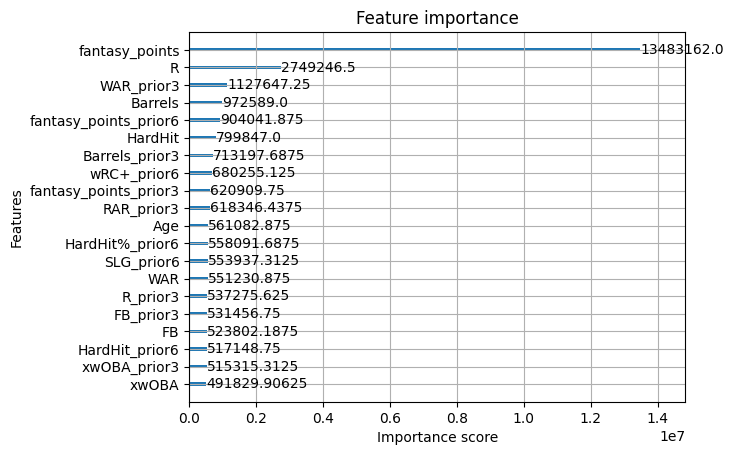

In [15]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=20)
plt.show()

In [16]:
batting_results = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_results)

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
37,Shohei Ohtani,2143.0,1610.302734,-532.697266,532.697266,2023,28,1635
21,Kyle Tucker,865.0,1526.494873,661.494873,661.494873,2023,26,1615
98,Rafael Devers,1314.0,1505.327637,191.327637,191.327637,2023,26,1423
63,Mookie Betts,1769.0,1433.100464,-335.899536,335.899536,2022,29,1477
223,Rafael Devers,1577.0,1431.622803,-145.377197,145.377197,2024,27,1314
...,...,...,...,...,...,...,...,...
229,Tyler Wade,242.0,239.845856,-2.154144,2.154144,2023,28,95
145,Joey Bart,575.0,238.728577,-336.271423,336.271423,2023,26,118
163,Brayan Rocchio,715.0,238.128922,-476.871078,476.871078,2023,22,124
86,Jose Herrera,273.0,220.898438,-52.101562,52.101562,2024,27,165


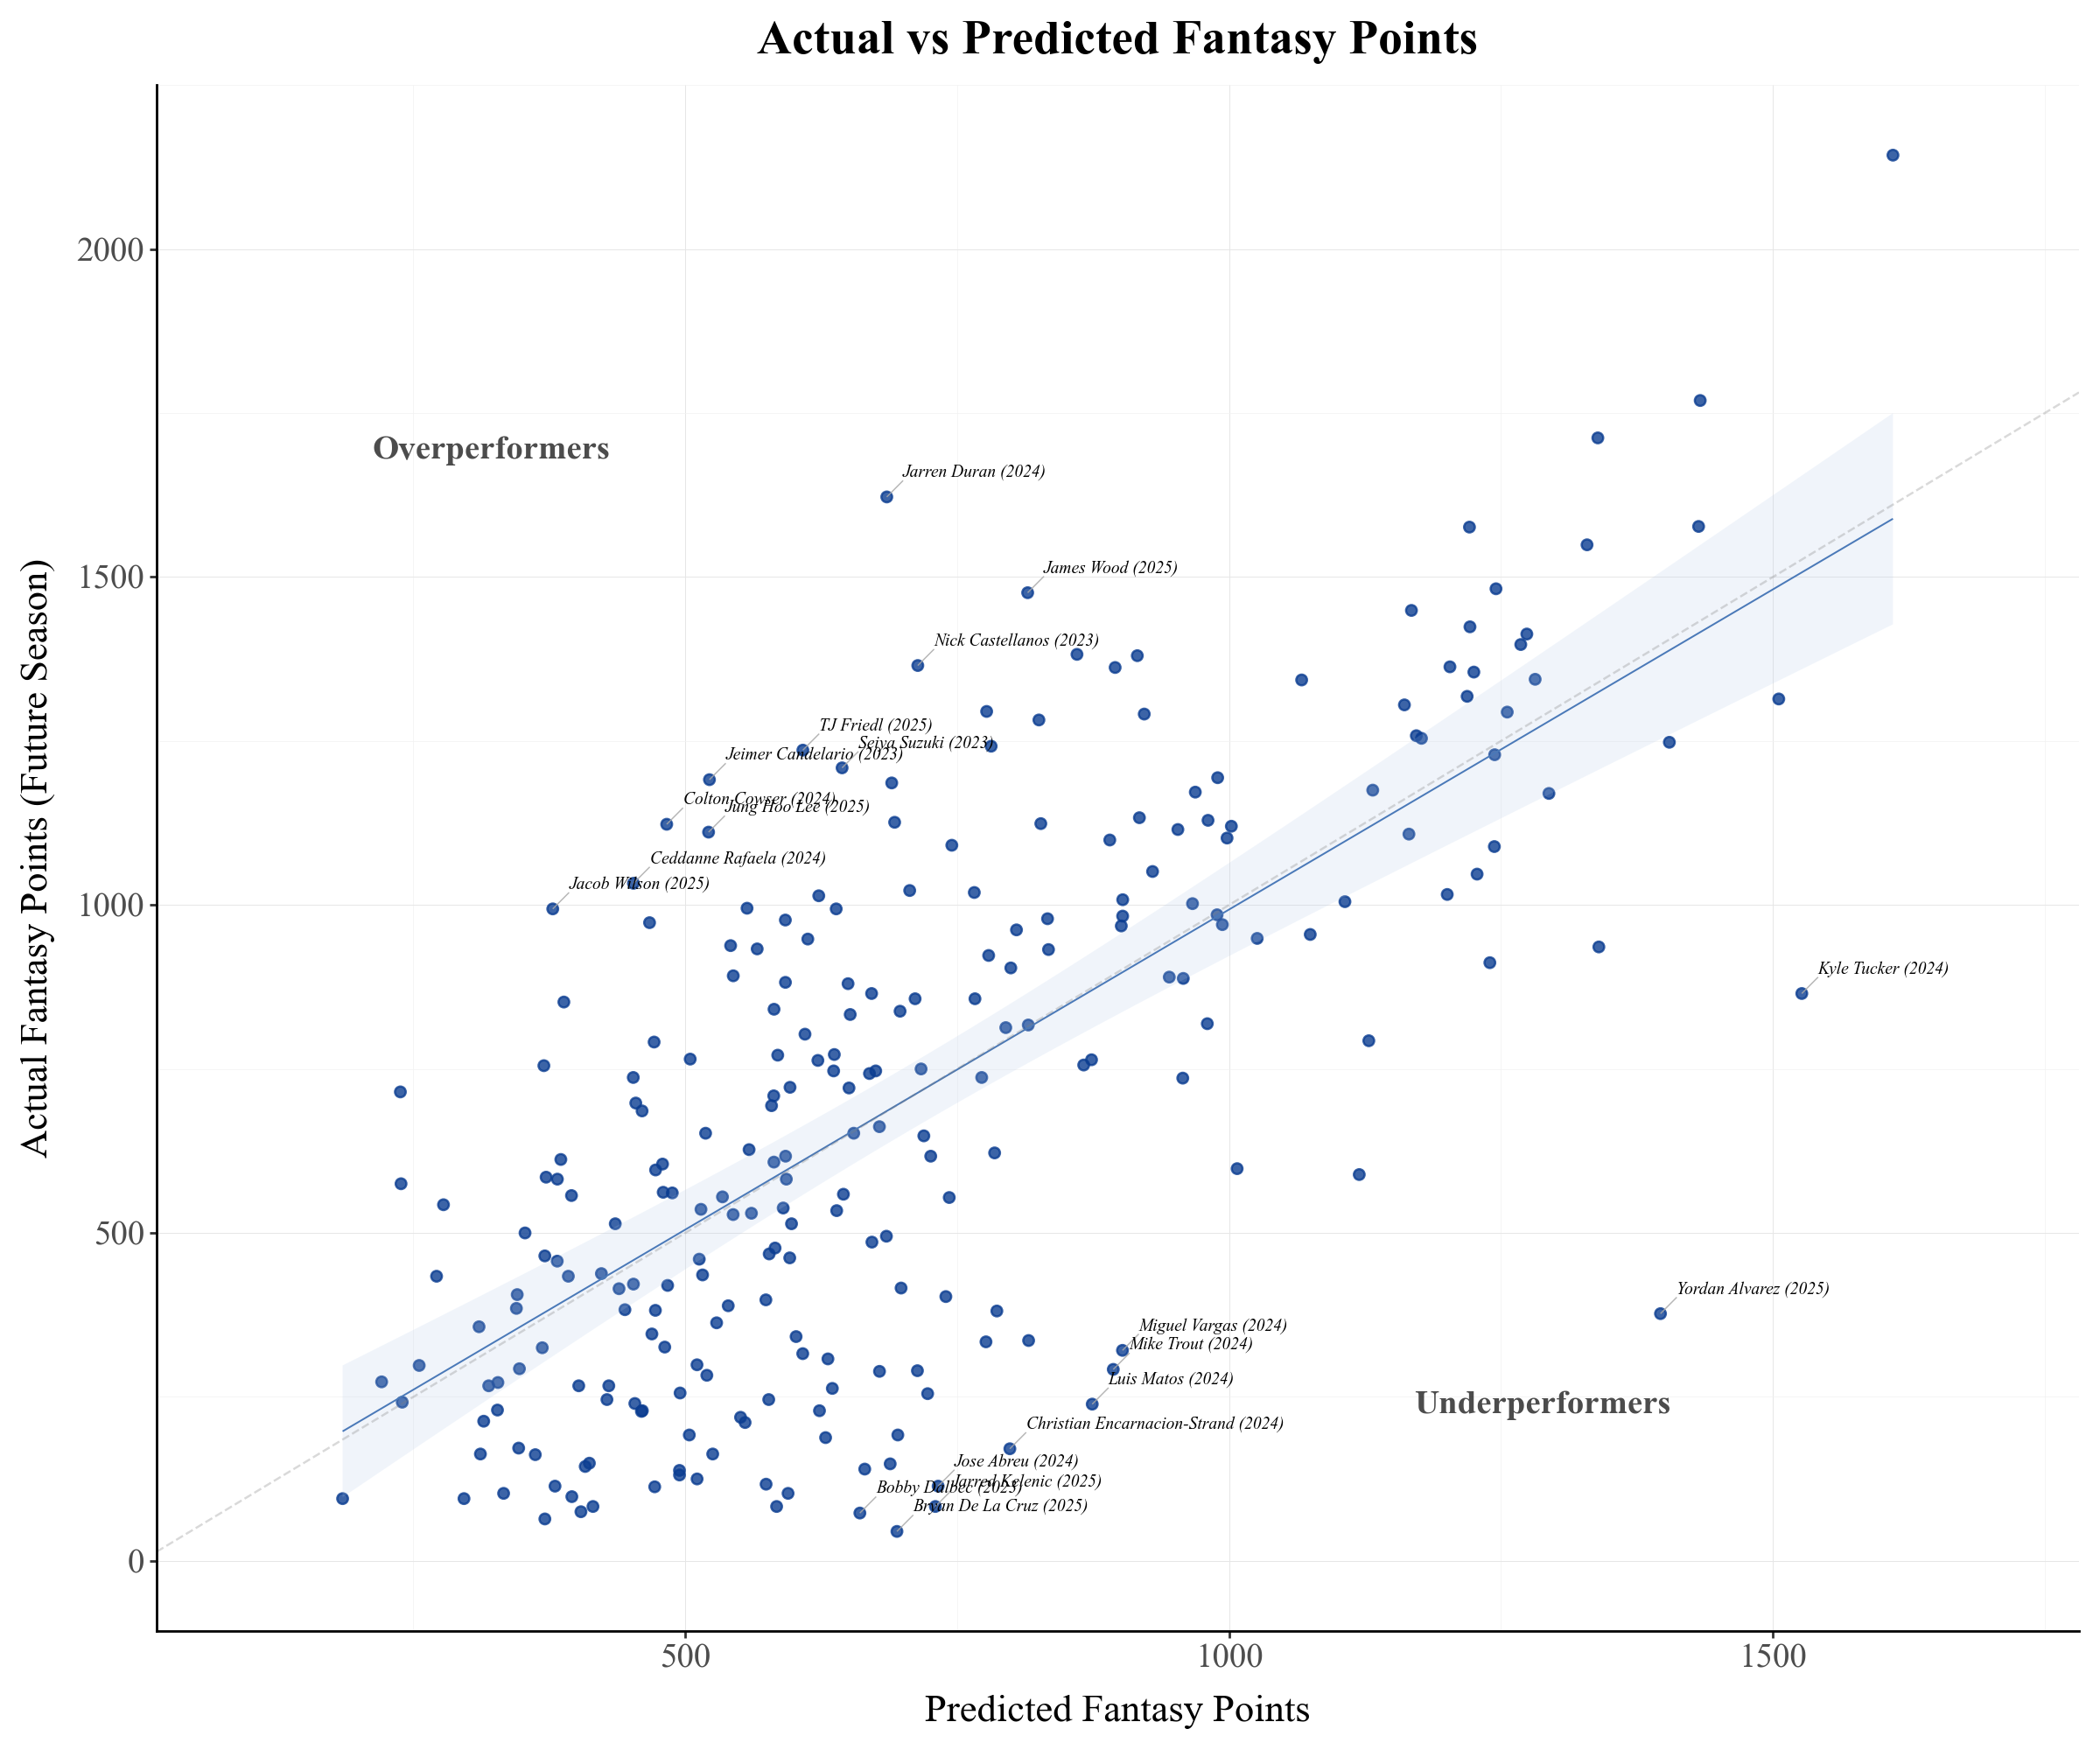

In [17]:
p1 = plot_actual_vs_pred_mlb(
    batting_results,
    top_n=20,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

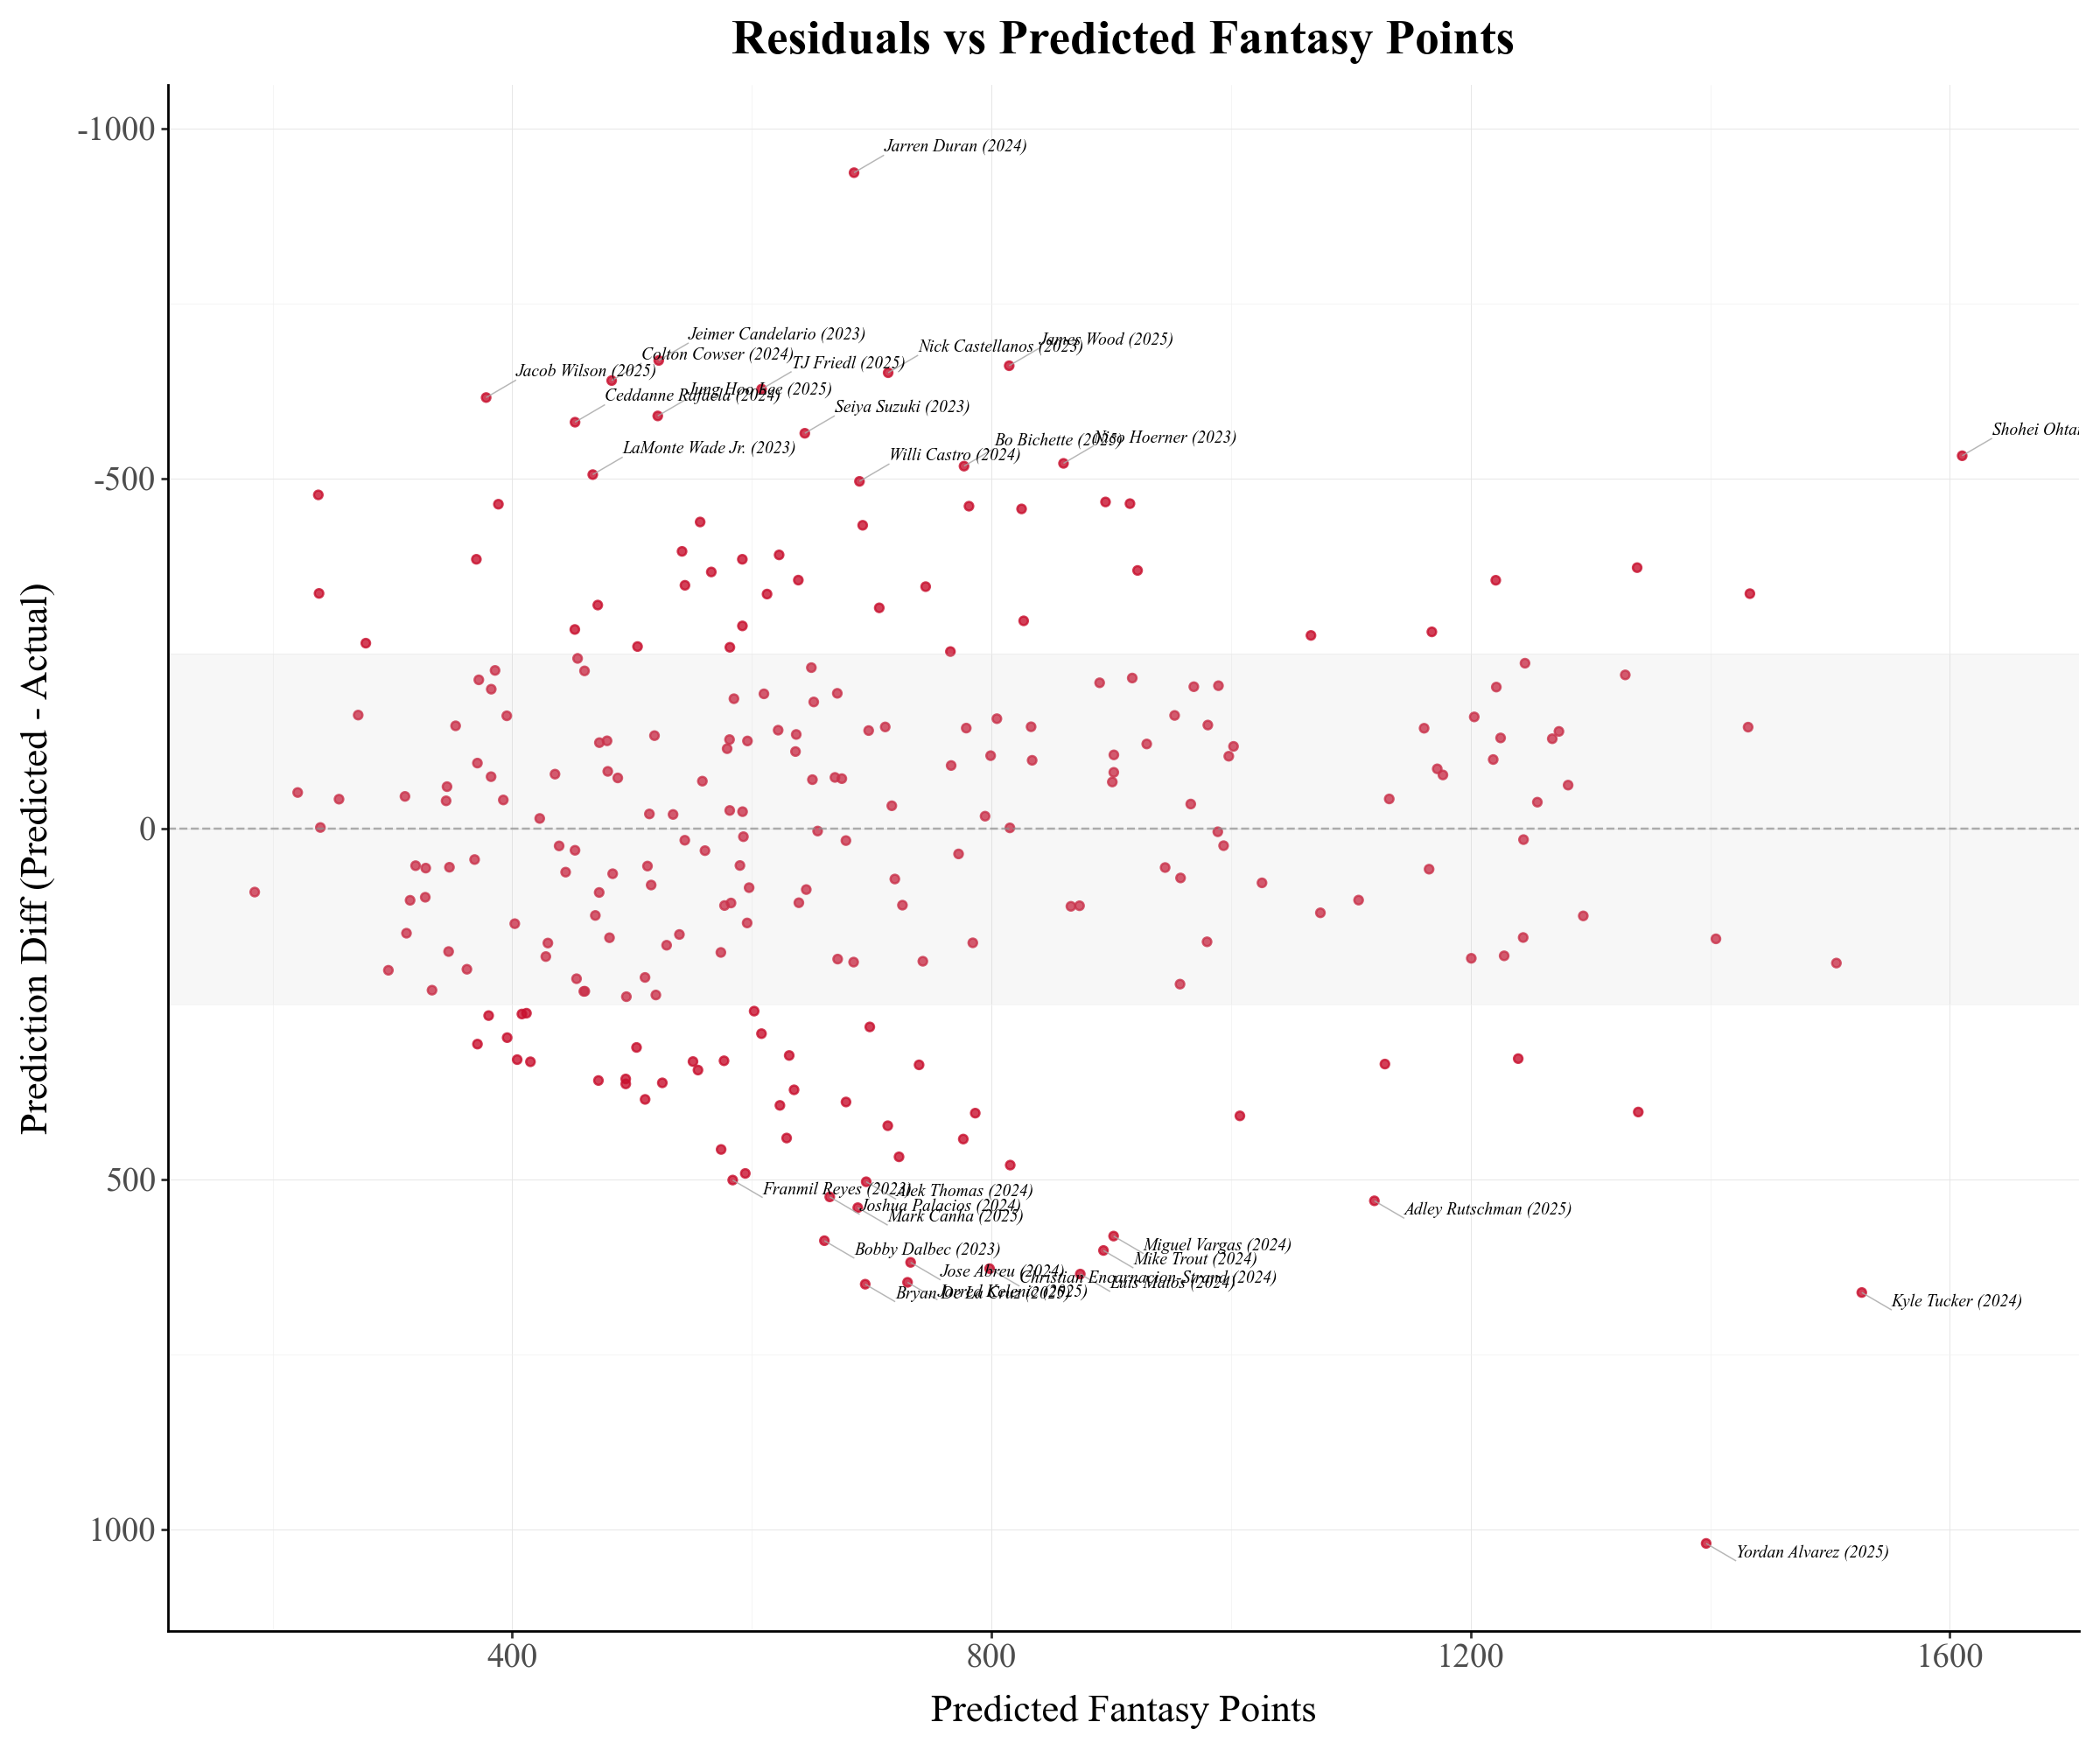

In [29]:
p2 = plot_resid_vs_pred_mlb(
    batting_results,
    band=250,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

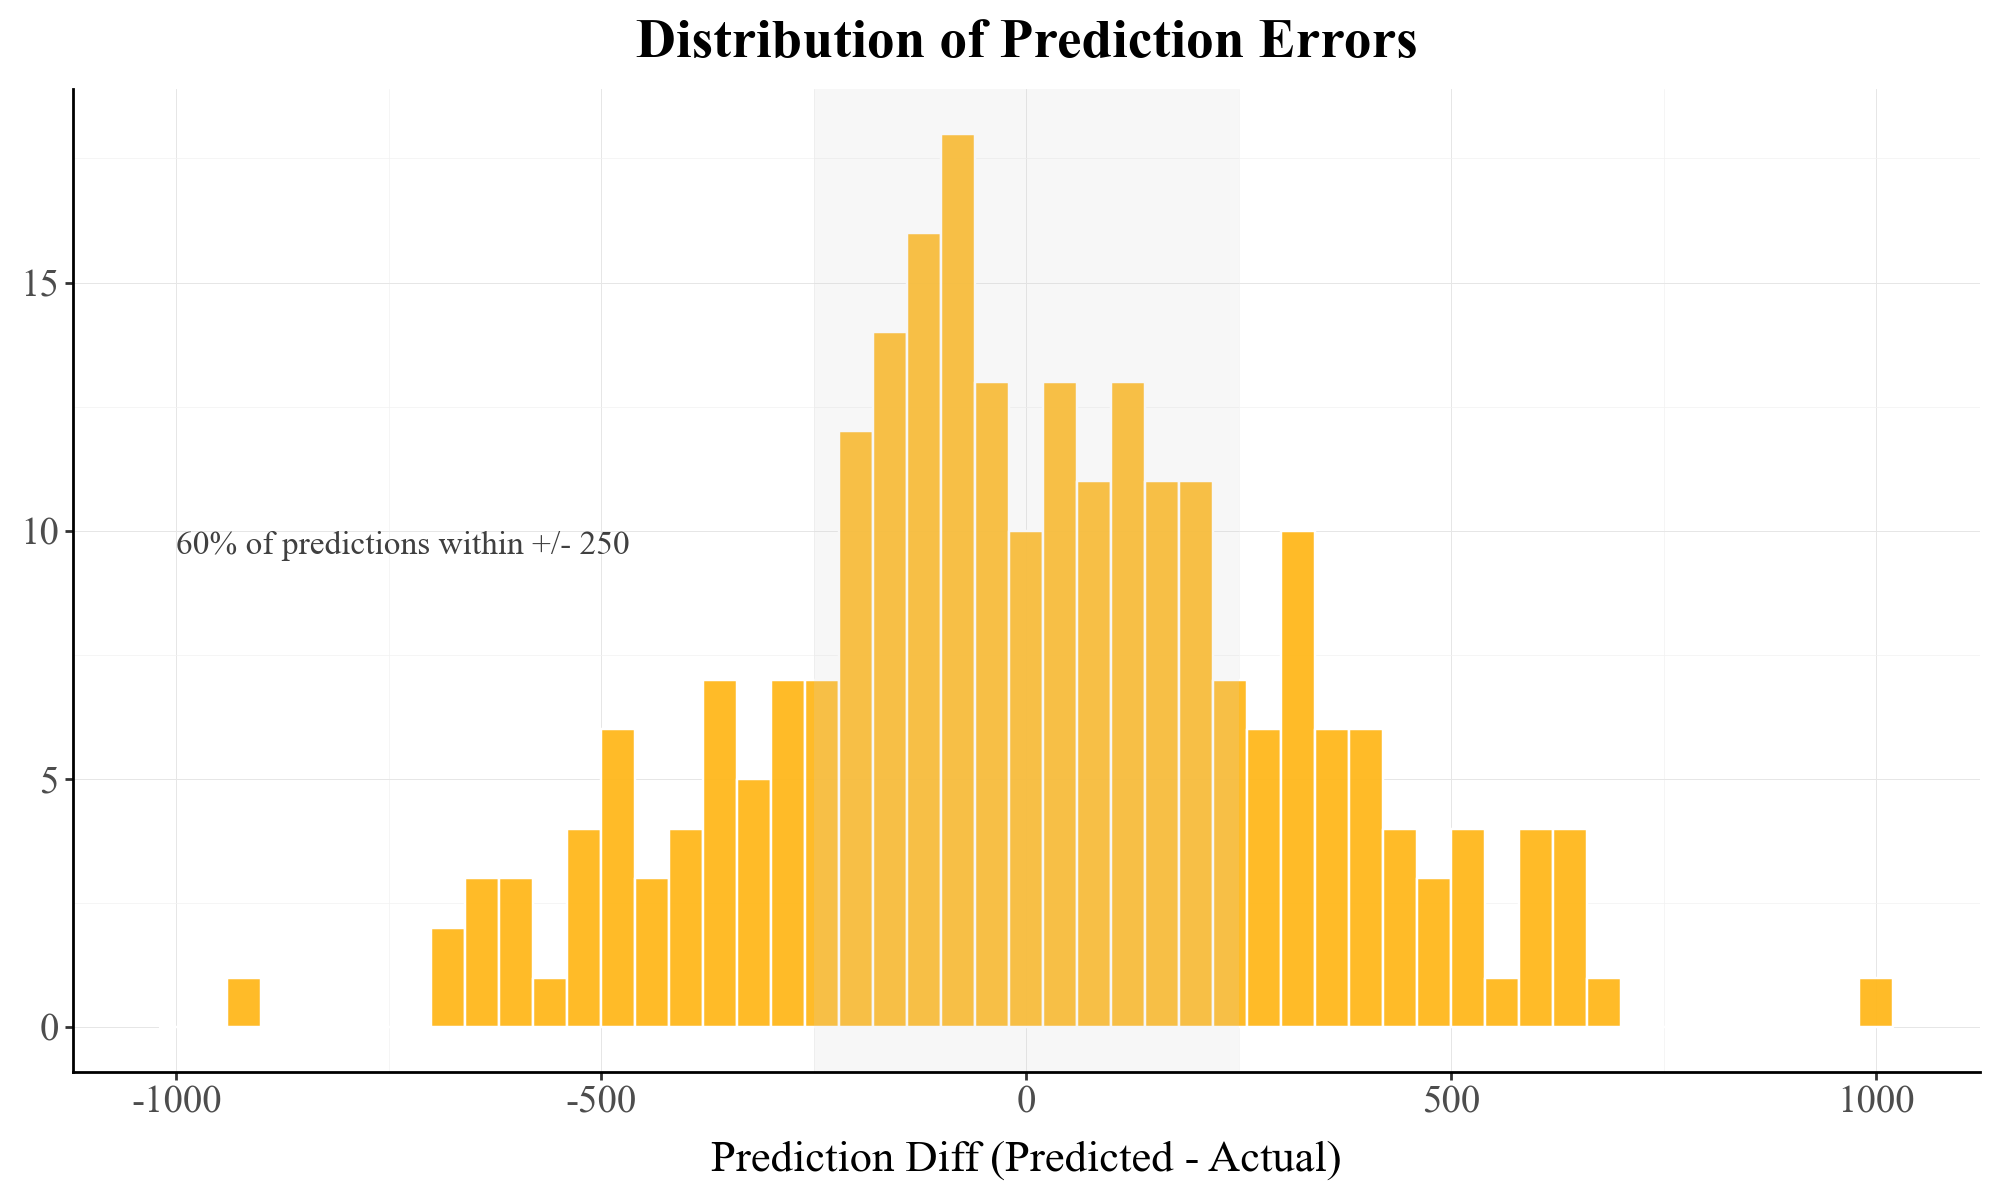

In [30]:
p3 = plot_resid_hist_mlb(
    batting_results,
    band=250,
    binwidth=40,
    x_annotate=-1000,    # custom annotation position
    y_annotate=10,      # custom annotation position
)
p3.show()

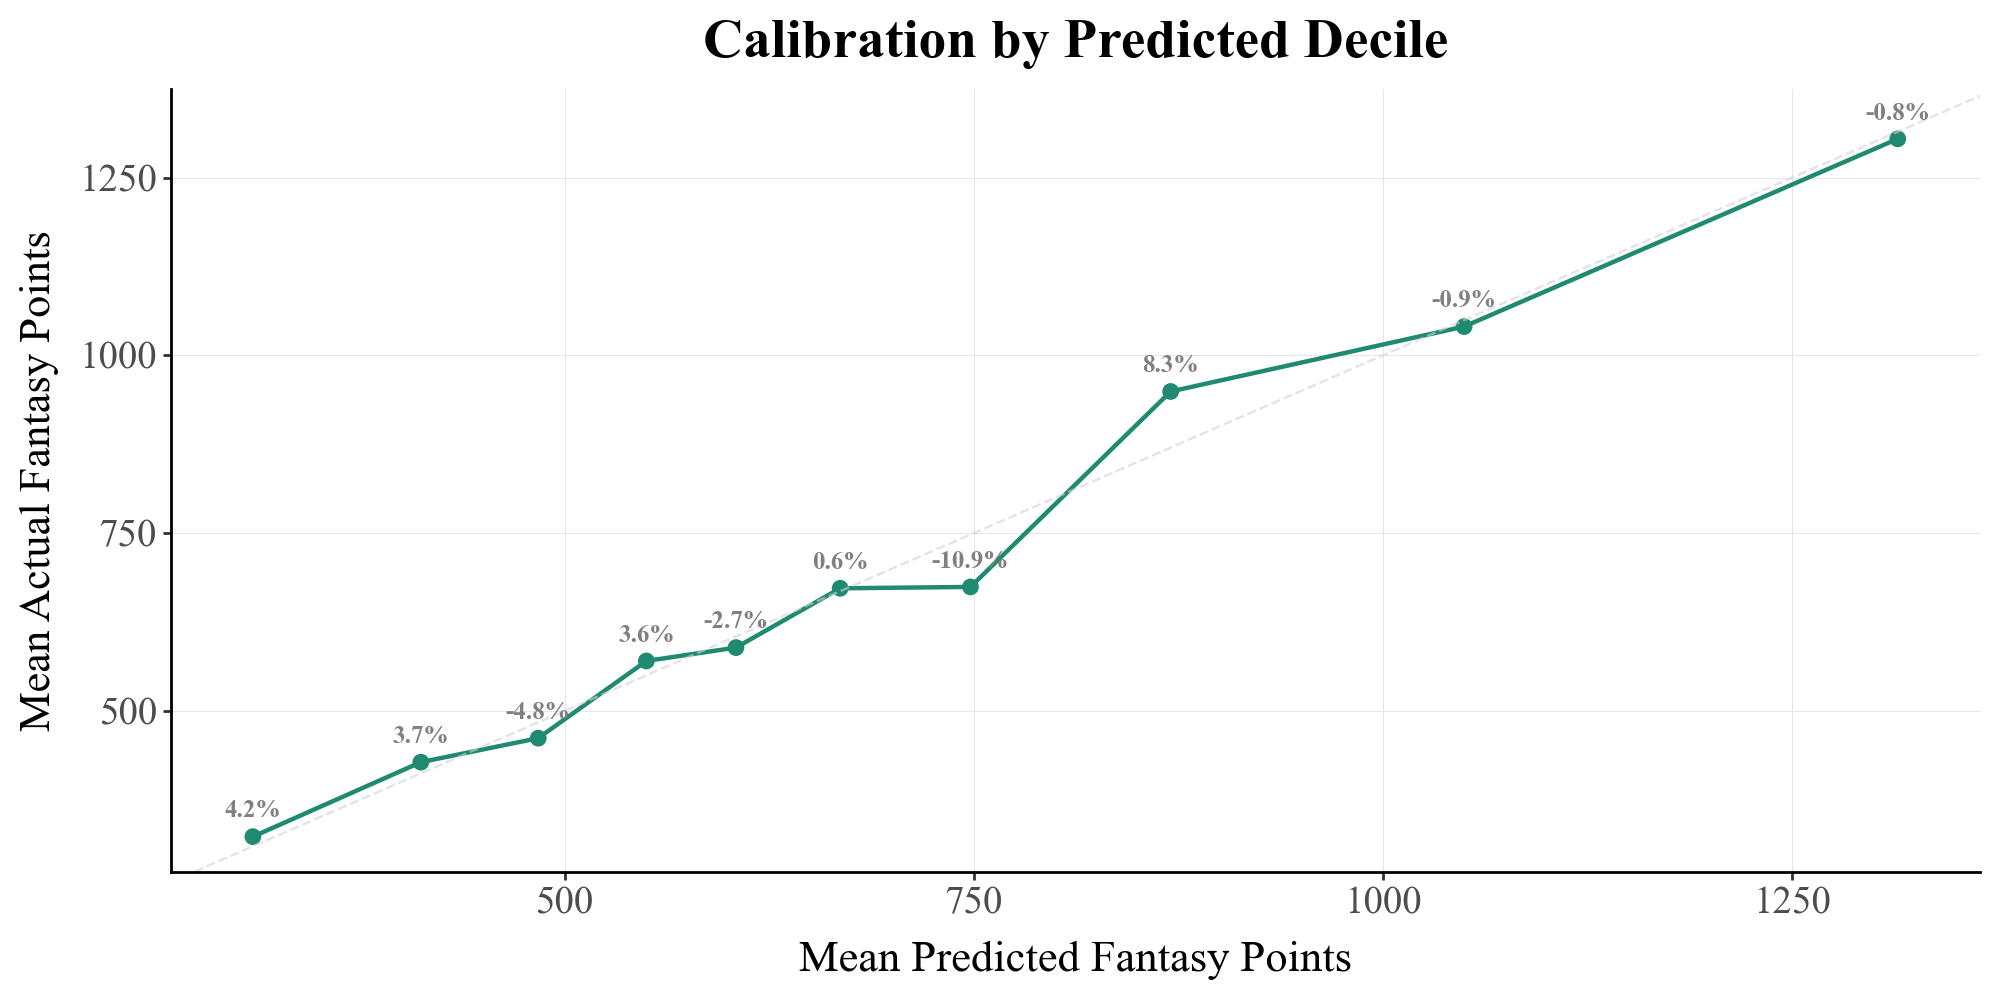

In [31]:
p4 = plot_decile_calib(batting_results)
p4.show()

# Creating baseline pitching predictions

In [21]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df)
# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 207.499 | MAE: 151.943 | R^2: 0.398


In [24]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp)

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
204,Logan Gilbert,1104.6,741.087402,-363.512598,363.512598,2023,26,965.6
178,Sonny Gray,959.3,740.869202,-218.430798,218.430798,2023,33,970.0
50,Merrill Kelly,334.6,740.471863,405.871863,405.871863,2023,34,957.6
37,Sonny Gray,955.6,735.227478,-220.372522,220.372522,2024,34,959.3
74,Yu Darvish,422.6,722.016907,299.416907,299.416907,2023,36,664.3
...,...,...,...,...,...,...,...,...
191,Kaleb Ort,134.6,219.567307,84.967307,84.967307,2023,31,98.0
147,Michael Petersen,81.0,219.081268,138.081268,138.081268,2024,30,75.6
22,Sammy Peralta,54.0,217.775650,163.775650,163.775650,2023,25,97.0
33,Bryan Shaw,192.6,217.502838,24.902838,24.902838,2022,34,255.3


# Pitching Predictions

In [22]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df)

# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=25,
    random_state=62820,
    id_cols=["IDfg"],
    max_depth_choices=MAX_DEPTH_CHOICES,
)

100%|██████████| 25/25 [00:16<00:00,  1.52trial/s, best loss: 200.4742915464138]
Best Parameters: {'learning_rate': 0.04653539498673496, 'max_depth': 6, 'subsample': 0.7254642877603361, 'colsample_bytree': 0.8190111906003454, 'min_child_weight': 1.5404076100804704, 'reg_lambda': 9.303883334466684, 'reg_alpha': 0.32703999059006905, 'gamma': 0.0013786074939222967}
[Best trial @ val] optimized=rmse | RMSE=200.474 | MAE=157.327 | ASYM=50728.521


In [25]:
# Create final model
pitching_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=62820,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 39
[Val] RMSE: 200.474 | MAE: 157.327 | R^2: 0.360 | ASYM: 50728.521
[Test] RMSE: 205.089 | MAE: 151.951 | R^2: 0.412 | ASYM: 55297.880


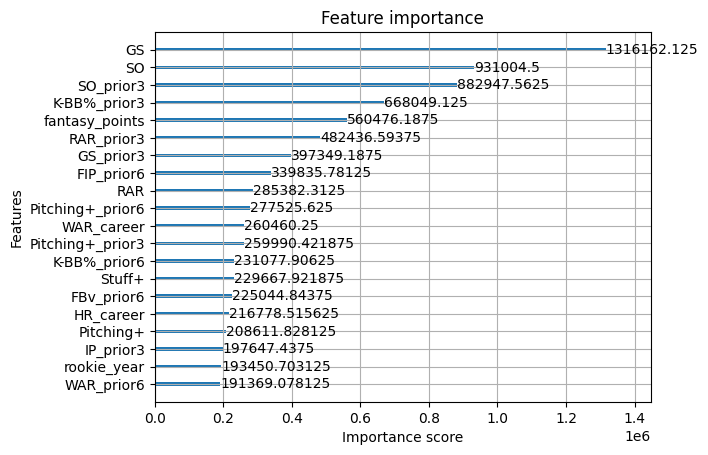

In [26]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=20)
plt.show()

In [27]:
pitching_results = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_results)

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
204,Logan Gilbert,1104.6,741.087402,-363.512598,363.512598,2023,26,965.6
178,Sonny Gray,959.3,740.869202,-218.430798,218.430798,2023,33,970.0
50,Merrill Kelly,334.6,740.471863,405.871863,405.871863,2023,34,957.6
37,Sonny Gray,955.6,735.227478,-220.372522,220.372522,2024,34,959.3
74,Yu Darvish,422.6,722.016907,299.416907,299.416907,2023,36,664.3
...,...,...,...,...,...,...,...,...
191,Kaleb Ort,134.6,219.567307,84.967307,84.967307,2023,31,98.0
147,Michael Petersen,81.0,219.081268,138.081268,138.081268,2024,30,75.6
22,Sammy Peralta,54.0,217.775650,163.775650,163.775650,2023,25,97.0
33,Bryan Shaw,192.6,217.502838,24.902838,24.902838,2022,34,255.3


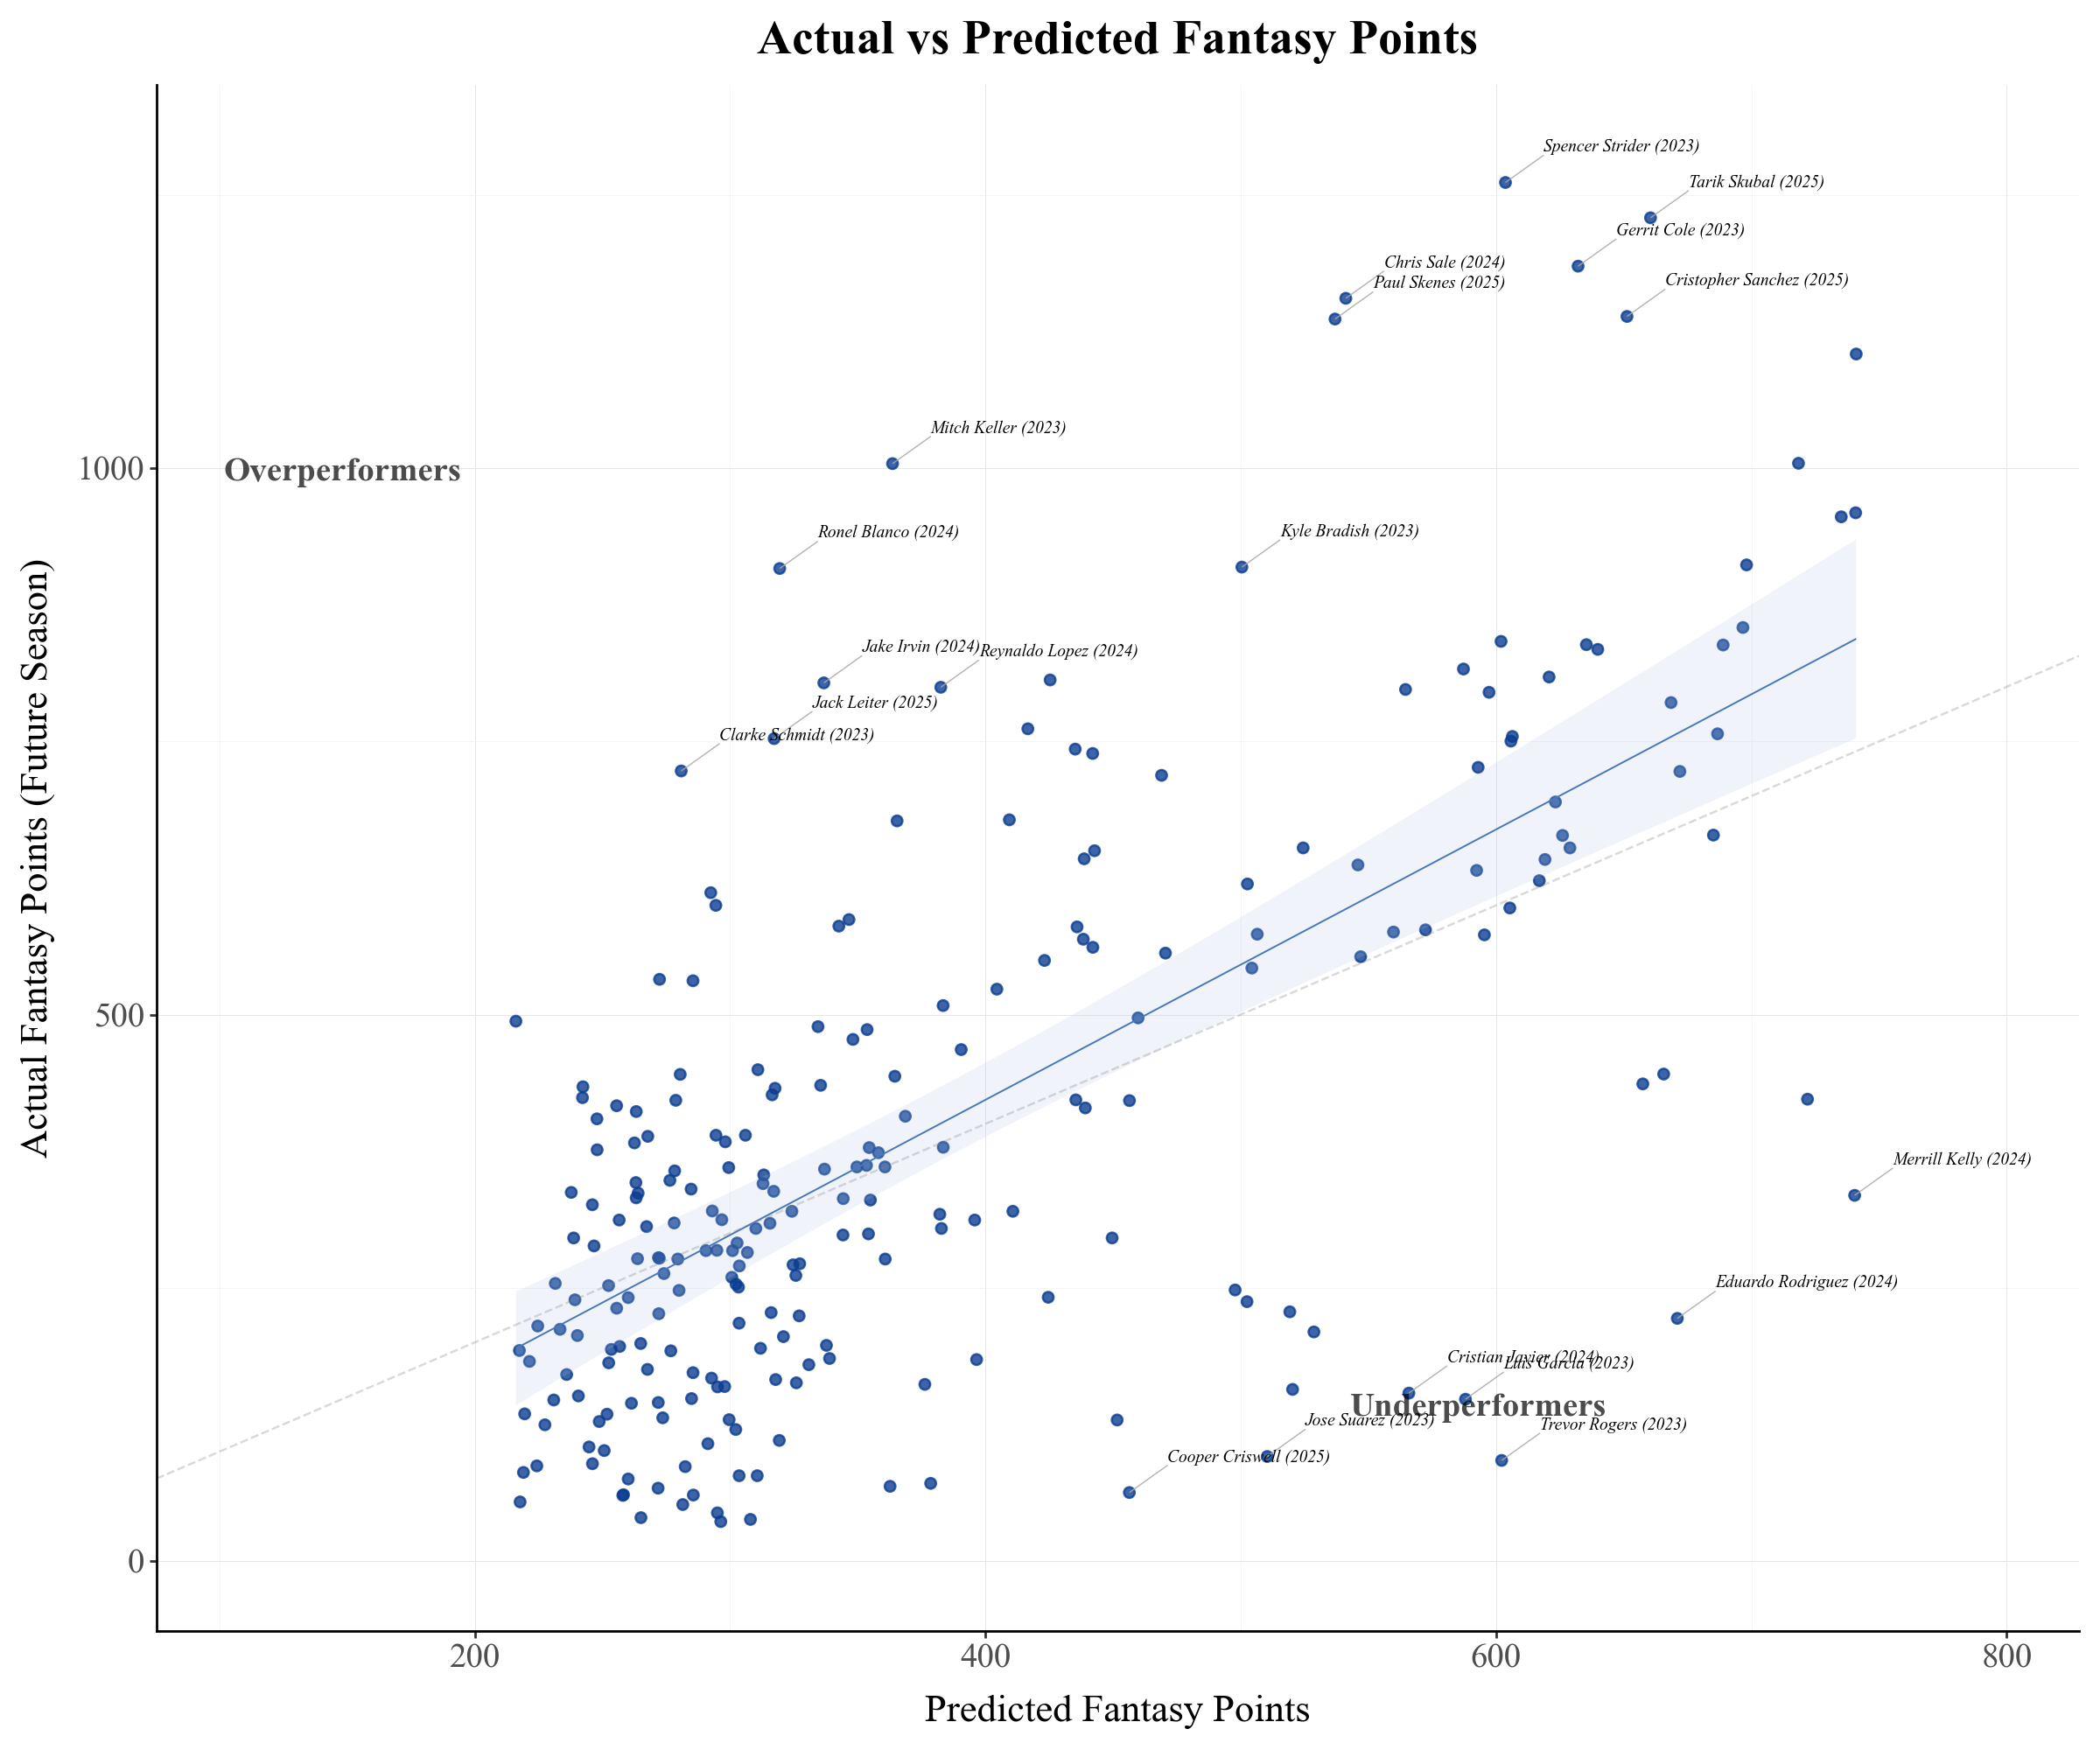

In [32]:
p1 = plot_actual_vs_pred_mlb(
    pitching_results,
    top_n=20,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

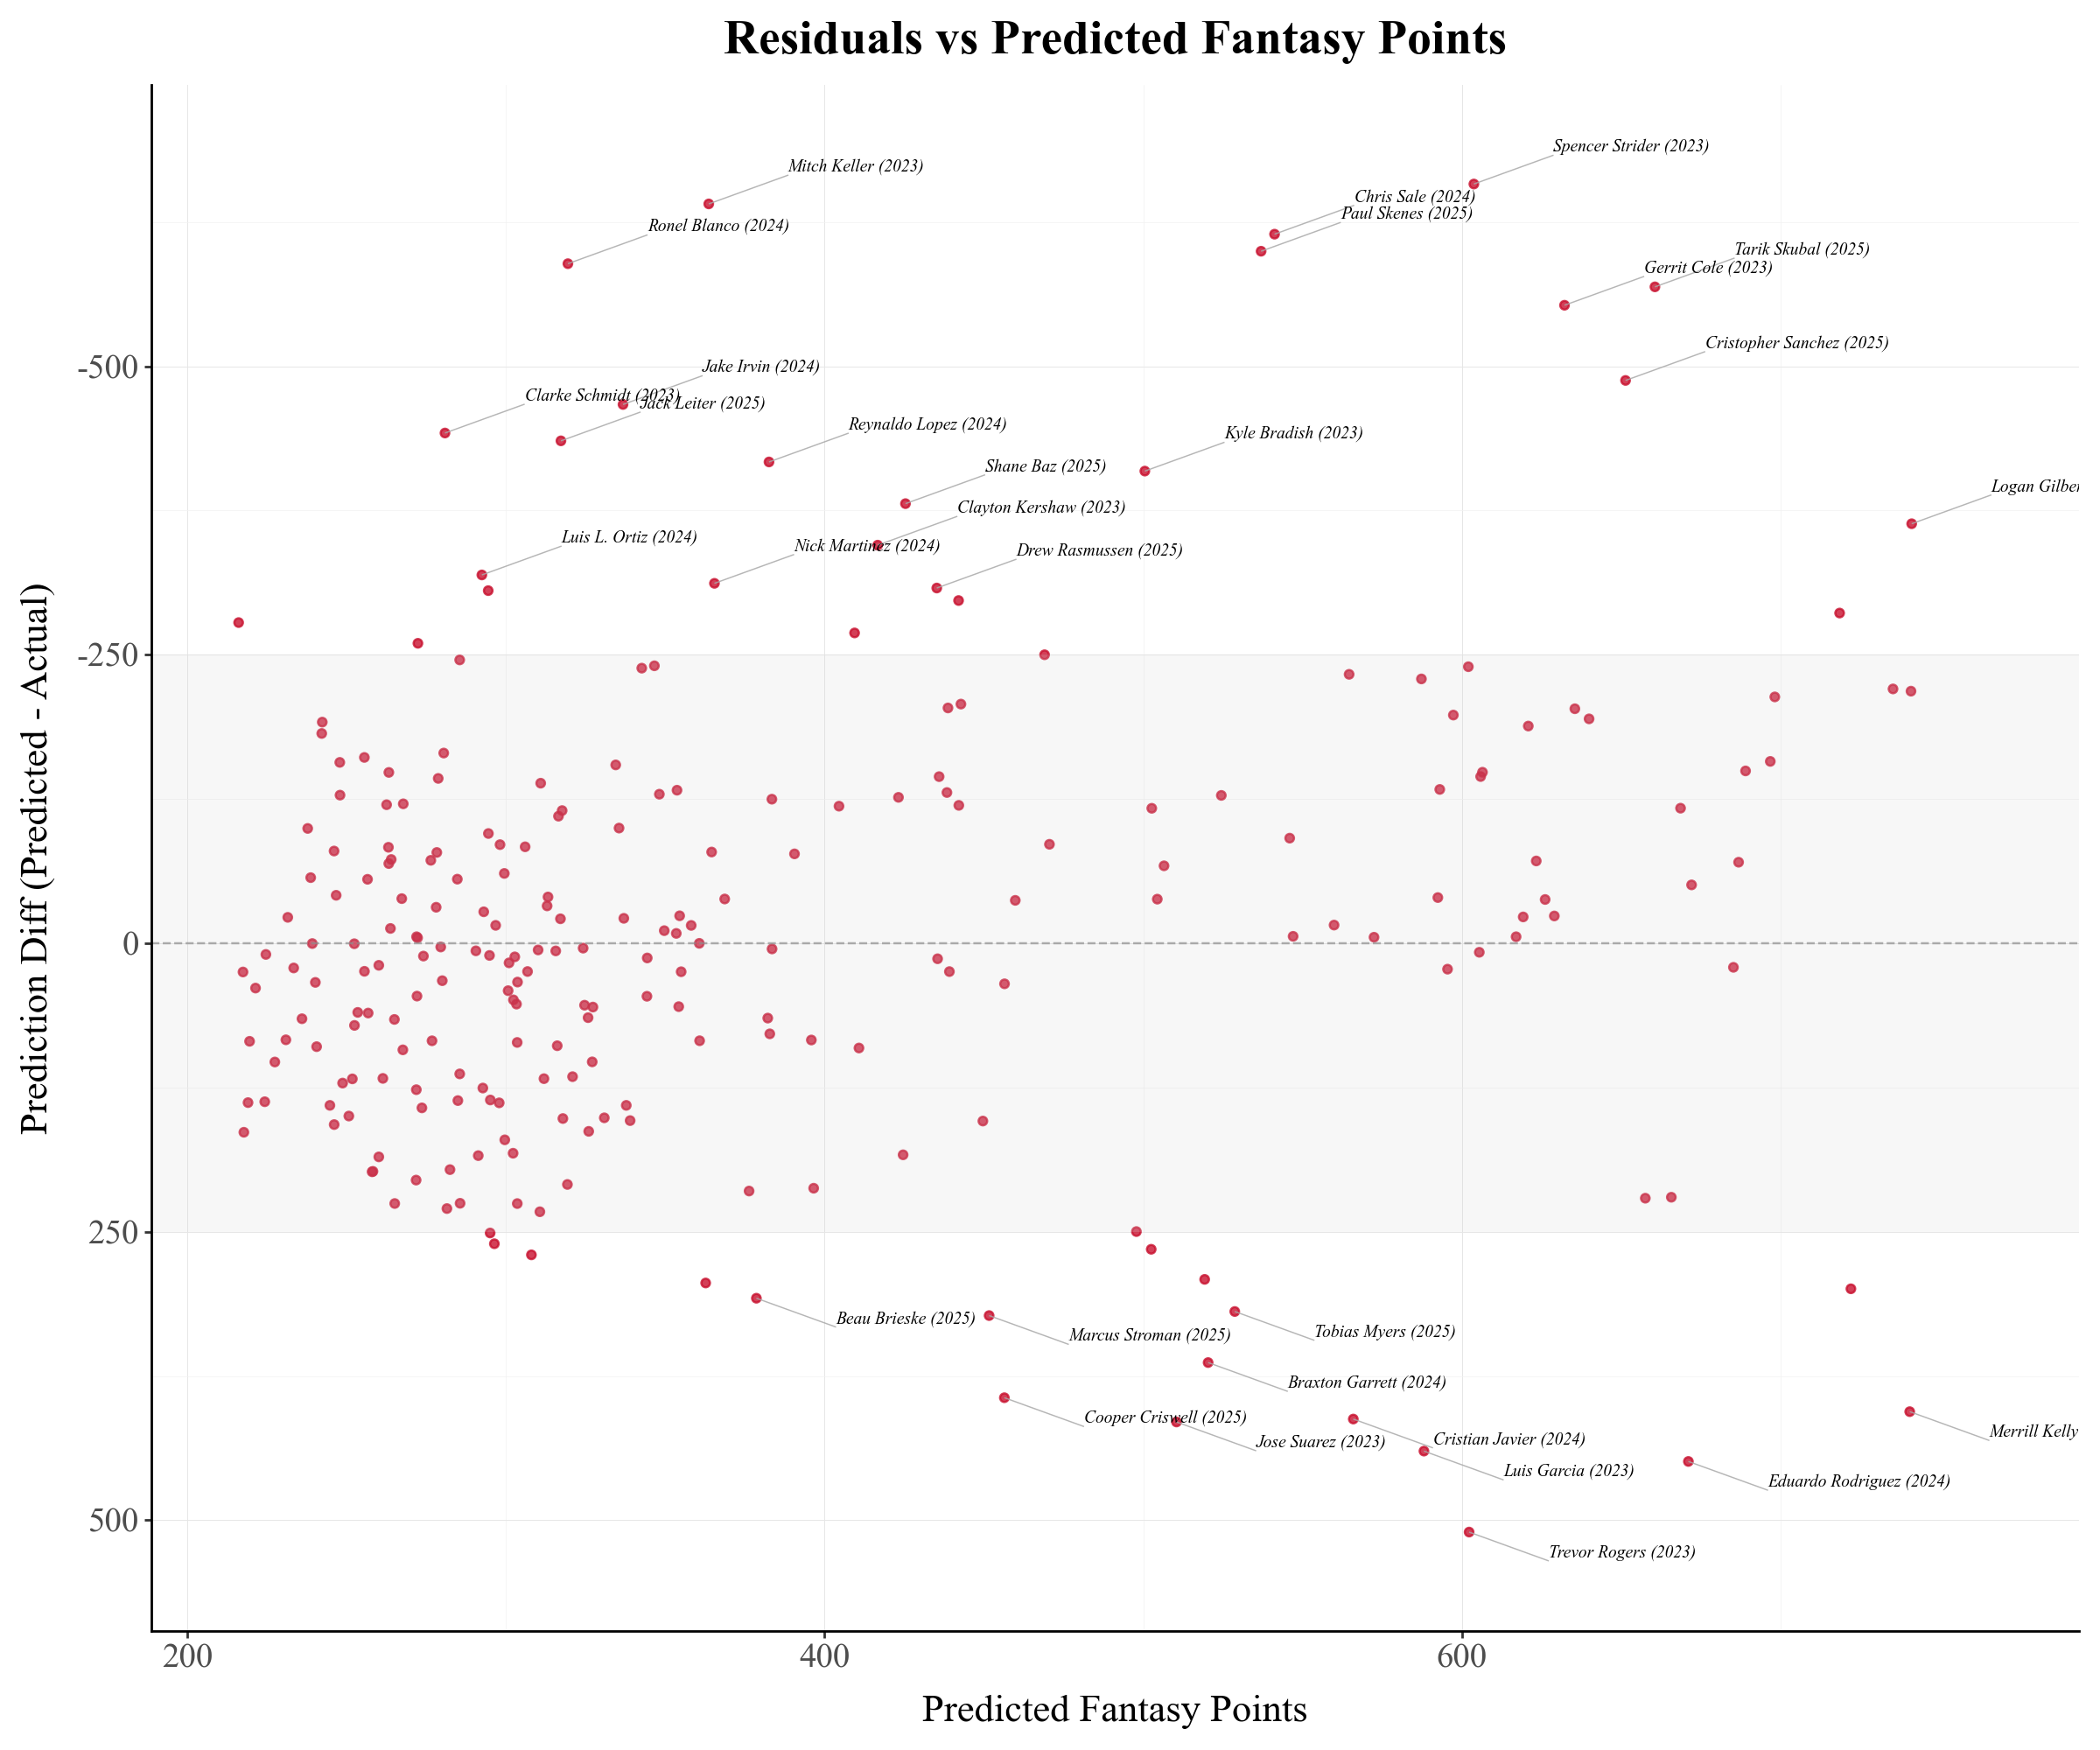

In [33]:
p2 = plot_resid_vs_pred_mlb(
    pitching_results,
    band=250,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

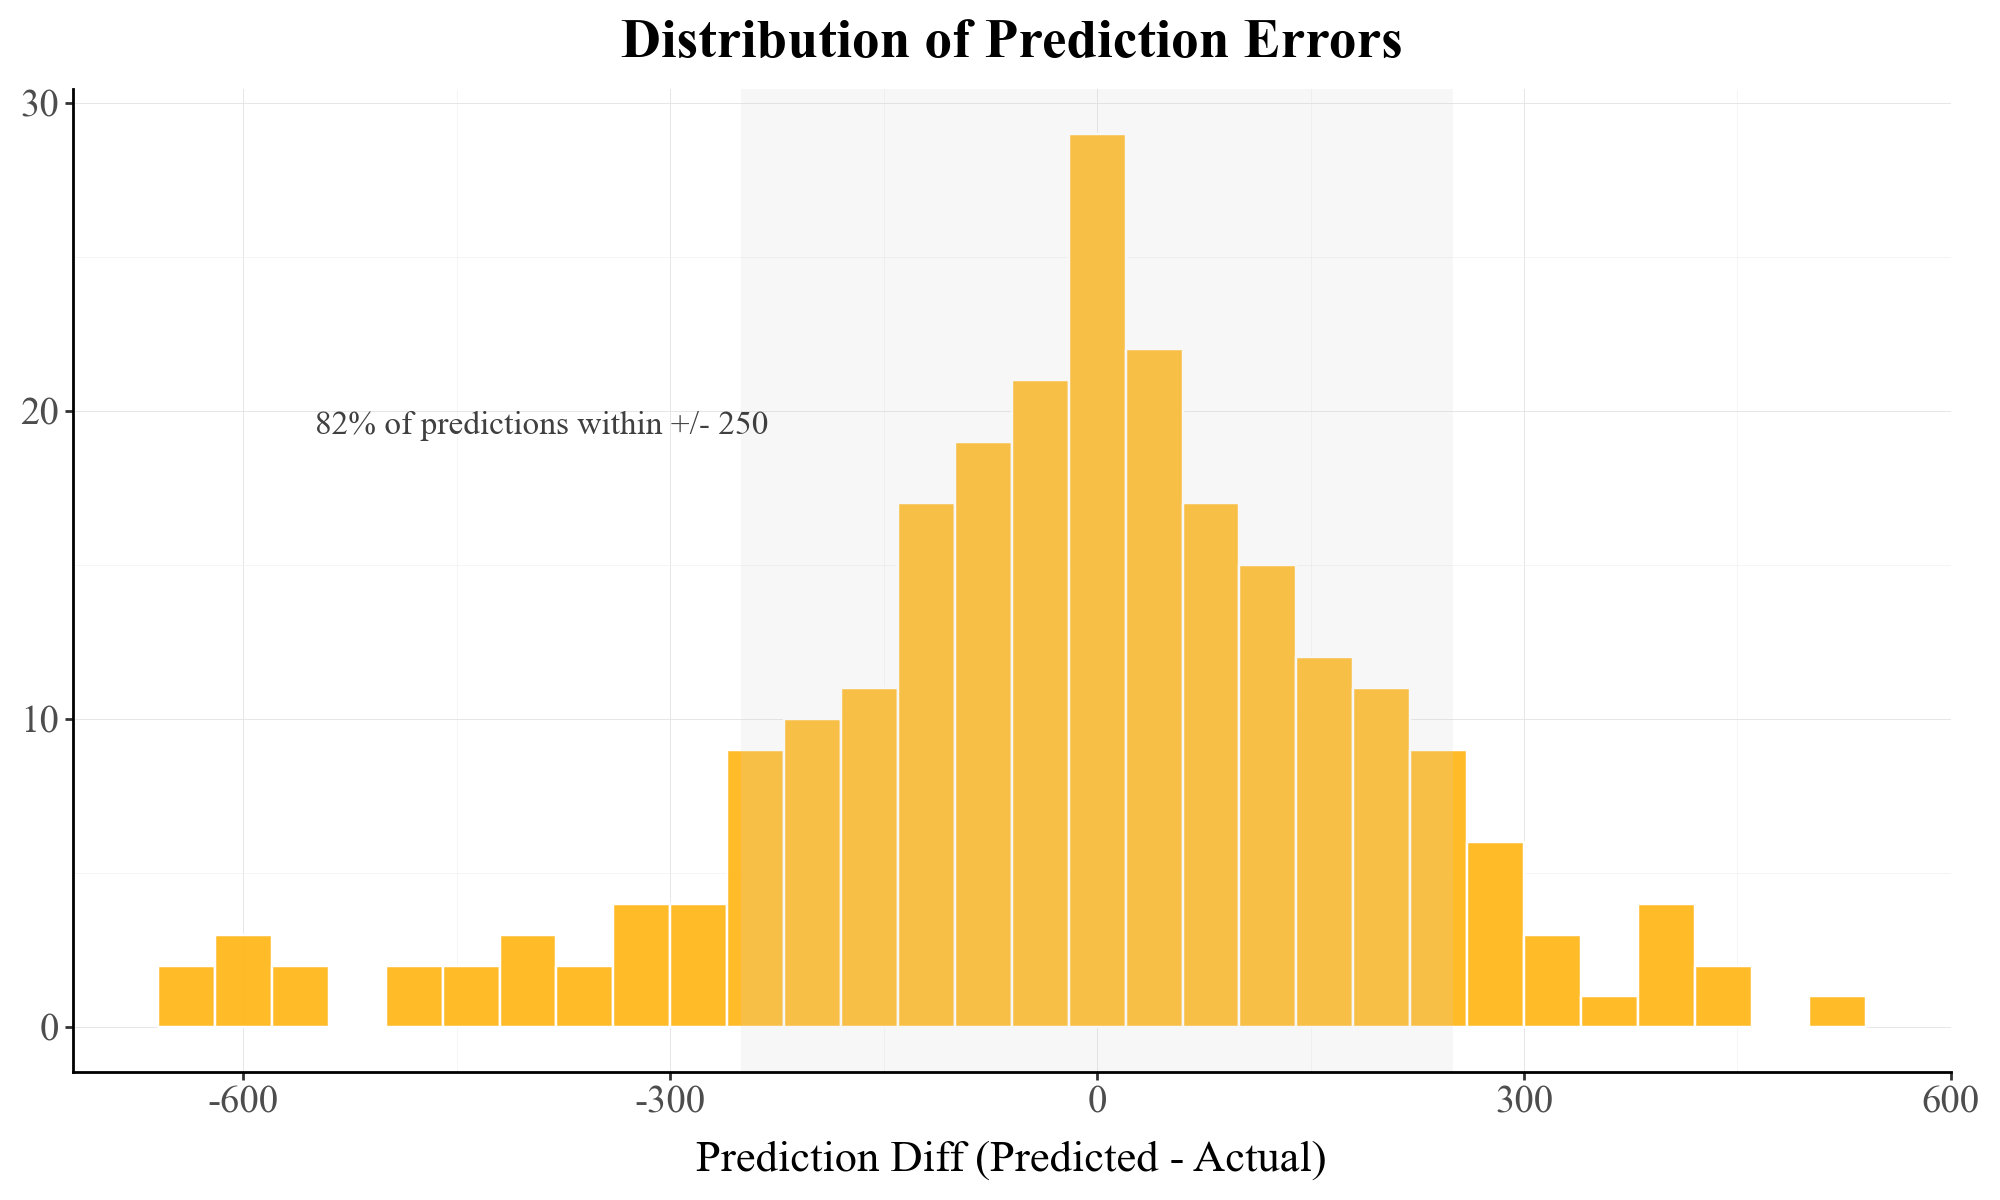

In [34]:
p3 = plot_resid_hist_mlb(
    pitching_results,
    band=250,
    binwidth=40,
    x_annotate=-550,    # custom annotation position
    y_annotate=20,      # custom annotation position
)
p3.show()

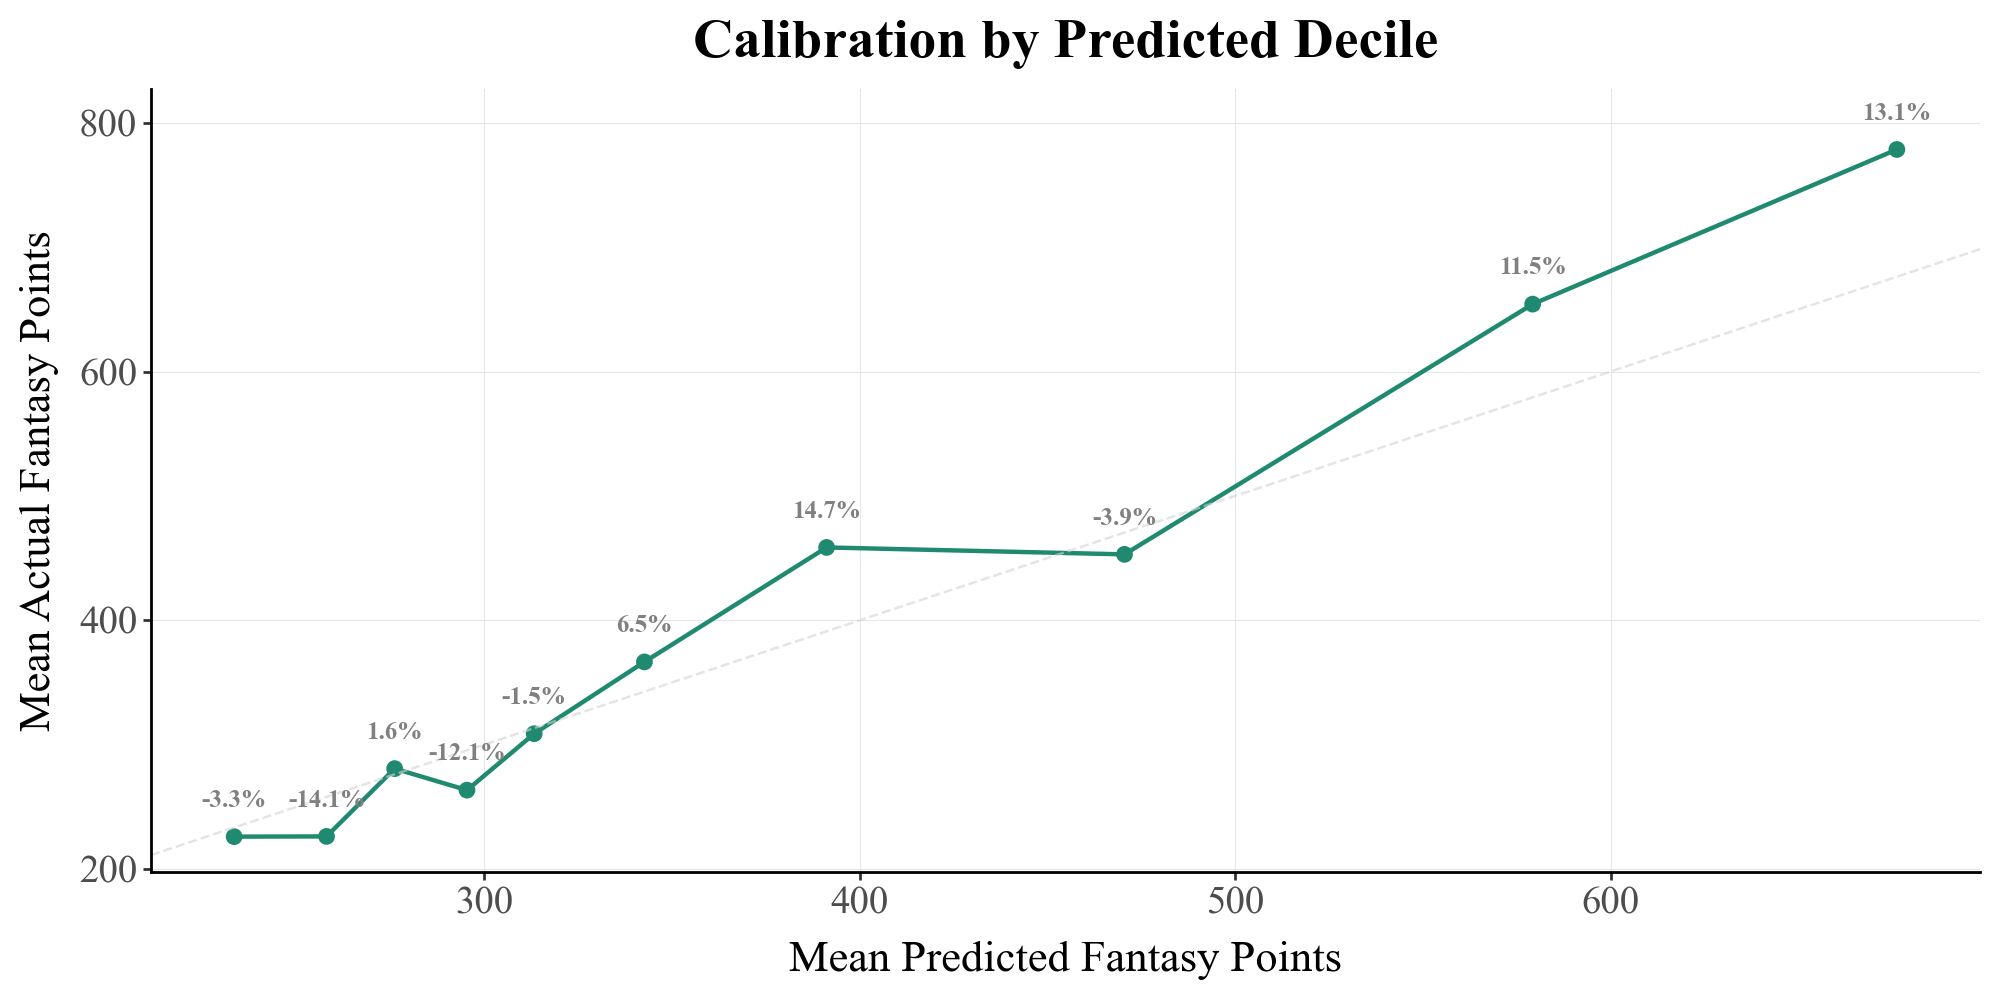

In [35]:
p4 = plot_decile_calib(pitching_results)
p4.show()

# Predicting Upcoming Season Player Performance

In [185]:
# import pandas as pd
# from pybaseball import batting_stats, pitching_stats, playerid_reverse_lookup
# from helper import calc_fantasy_points_batting, calc_fantasy_points_pitching, add_suffix_to_columns, save_data, load_training_data
# def validate_covid_impact(season, years):
#     """
#     This function checks if the year 2020 occurred during the specified number of years leading up to the given season.
#     """
#     start_year = season - years
#     end_year = season
#     return 2020 in range(start_year, end_year + 1)

# def player_data(df: pd.DataFrame) -> pd.DataFrame:
#     """
#     Pulls player data from the pybaseball API and merges it with the provided DataFrame to obtain player rookie seasons.

#     Parameters:
#     df (pd.DataFrame): The DataFrame to which the player data will be added.

#     Returns:
#     pd.DataFrame: The DataFrame with the player data added.
#     """

#     player_ids = df['IDfg'].unique().tolist()
#     player_ids = playerid_reverse_lookup(player_ids, key_type='fangraphs').filter(items = ['key_fangraphs', 'mlb_played_first'])
#     player_ids = player_ids.rename(columns = {'key_fangraphs': 'IDfg', 'mlb_played_first': 'rookie_year'})
#     df = df.merge(player_ids, on = 'IDfg', how = 'left')
    
#     # Add total years in league to the data for each player for context on eligible playing years
#     df['years_in_league'] = df['Season'] - df['rookie_year']
#     return df

# def pull_prediction_data(prediction_year: int, agg_years: int, batting_stat_cols: list, pitching_stat_cols: list) -> tuple:
#     """
#     Pulls and processes batting and pitching data for the specified years.

#     Parameters:
#     end_year (int): The end year for the data pull.
#     agg_years (int): The number of years to aggregate for prior data.
#     batting_stat_cols (list): List of columns to include in the batting data.
#     pitching_stat_cols (list): List of columns to include in the pitching data.

#     Returns:
#     tuple: A tuple containing two DataFrames, one for batting data and one for pitching data.
#     """
#     # Initialize empty DataFrames
#     batting_df = pd.DataFrame()
#     pitching_df = pd.DataFrame()

#     # Creating start and end years for the aggregated data pull of prior player seasons
#     end_year_prior = prediction_year - 1
#     start_year_prior = end_year_prior - agg_years

#     # Pulling batting stats
#     batting_df_current = (
#         batting_stats(start_season = prediction_year, # Selecting a single season for most recent stats
#                         qual = 50,
#                         split_seasons = True)
#                         .filter(items = batting_stat_cols)
#     )
#     calc_fantasy_points_batting(batting_df_current, 'fantasy_points')

#     batting_df_prior = (
#         batting_stats(start_season = start_year_prior, 
#                         end_season = end_year_prior,
#                         qual = 50,
#                         split_seasons = False)
#                         .filter(items = batting_stat_cols)
#     )
#     batting_df_prior = batting_df_prior.drop(columns = ['Name', 'Age']) # Dropping redundant columns for joining
#     calc_fantasy_points_batting(batting_df_prior, 'fantasy_points_prior')
#     batting_df_prior = add_suffix_to_columns(batting_df_prior, '_prior', exclude_columns = ['IDfg', 'fantasy_points_prior'])

#     # Combining batting features into single dataframe and replace NaN values with 0
#     batting_df_current = (batting_df_current.merge(batting_df_prior, on = 'IDfg', how = 'left')
#     )

#     # Pulling pitching stats
#     pitching_df_current = (
#         pitching_stats(start_season = prediction_year, # Selecting a single season for most recent stats
#                         qual = 20,
#                         split_seasons = True)
#                         .filter(items = pitching_stat_cols)
#     )
#     calc_fantasy_points_pitching(pitching_df_current, 'fantasy_points')

#     pitching_df_prior = (
#         pitching_stats(start_season = start_year_prior, 
#                         end_season = end_year_prior,
#                         qual = 20,
#                         split_seasons = False)
#                         .filter(items = pitching_stat_cols)
#     )
#     pitching_df_prior = pitching_df_prior.drop(columns = ['Name', 'Age']) # Dropping redundant columns for joining
#     calc_fantasy_points_pitching(pitching_df_prior, 'fantasy_points_prior')
#     pitching_df_prior = add_suffix_to_columns(pitching_df_prior, '_prior', exclude_columns = ['IDfg', 'fantasy_points_prior'])

#     # Combining pitching features into single dataframe & replace NaN values with 0
#     pitching_df_current = (pitching_df_current.merge(pitching_df_prior, on = 'IDfg', how = 'left')
#     )

#     # Append the results to the main DataFrames
#     batting_df = pd.concat([batting_df, batting_df_current], ignore_index=True)
#     pitching_df = pd.concat([pitching_df, pitching_df_current], ignore_index=True)

#     # Add a column to indicate if the season is during the COVID-19 pandemic
#     batting_df['covid_season'] = batting_df['Season'] == 2020
#     pitching_df['covid_season'] = pitching_df['Season'] == 2020

#     # Add a column to indicate if the prior seasons were during the COVID-19 pandemic
#     batting_df['covid_impact'] = batting_df['Season'].apply(lambda x: validate_covid_impact(x, agg_years))
#     pitching_df['covid_impact'] = pitching_df['Season'].apply(lambda x: validate_covid_impact(x, agg_years))

#     # Add player rookie seasons onto the data, helps with modeling new players vs veterans
#     batting_df = player_data(batting_df)
#     pitching_df = player_data(pitching_df)

#     # Replacing NaN values with 0
#     batting_df.fillna(0, inplace=True)
#     pitching_df.fillna(0, inplace=True)

#     return batting_df, pitching_df

In [4]:
batting_new, pitching_new = pull_prediction_data(year = PRED_YEAR,
                                    agg_years=AGG_YEARS, 
                                    batting_stat_cols=batting_stat_cols, 
                                    pitching_stat_cols=pitching_stat_cols,
                                    batting_career_cols=batting_career_cols,
                                    pitching_career_cols=pitching_career_cols,
                                    career_window_years=10)

Pulling data for year: 2025
Gathering player lookup table. This may take a moment.
Data saved successfully.
Data pull complete.


In [75]:
batting_predictions = batting_model.predict(batting_new.drop(columns=['IDfg', 'Name', 'fantasy_points_future']))
pitching_predictions = pitching_model.predict(pitching_new.drop(columns=['IDfg', 'Name', 'fantasy_points_future']))

In [76]:
batting_new['fantasy_points_pred'] = batting_predictions
pitching_new['fantasy_points_pred'] = pitching_predictions

batting_new.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_new.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)  

In [77]:
display(batting_new)

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,ISO_career,wRC+_career,WAR_career,fantasy_points_career,covid_season,covid_impact_prior2,covid_impact_prior4,rookie_year,years_in_league,fantasy_points_pred
13,19611,2024,Vladimir Guerrero Jr.,25,159,616,199,124,44,1,...,0.211,130.0,11.5,5992.0,False,False,True,2019.0,5.0,1592.103394
3,20123,2024,Juan Soto,25,157,576,166,90,31,4,...,0.240,153.0,28.2,8099.0,False,False,True,2018.0,6.0,1573.104126
15,19556,2024,Yordan Alvarez,27,147,552,170,99,34,2,...,0.293,166.0,18.0,5057.0,False,False,True,2019.0,5.0,1476.901489
2,19755,2024,Shohei Ohtani,29,159,636,197,98,38,7,...,0.282,146.0,19.6,6947.0,False,False,True,2018.0,6.0,1450.329590
28,17350,2024,Rafael Devers,27,138,525,143,76,34,5,...,0.229,124.0,21.6,7909.0,False,False,True,2017.0,7.0,1369.940918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,5760,2024,Avisail Garcia,33,18,50,12,9,1,0,...,0.157,99.0,8.1,7245.0,False,False,True,2012.0,12.0,206.024170
451,25353,2024,Michael Stefanic,28,40,110,24,20,4,0,...,0.049,80.0,0.1,187.0,False,False,True,2022.0,2.0,201.671402
408,14128,2024,Joey Gallo,30,76,223,36,17,9,0,...,0.269,109.0,13.4,6622.0,False,False,True,2015.0,9.0,199.123947
413,25111,2024,David Hensley,28,23,52,11,9,1,0,...,0.097,58.0,-0.5,191.0,False,False,True,2022.0,2.0,186.308456


In [78]:
display(pitching_new)

,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,K/BB_career,K-BB%_career,WAR_career,fantasy_points_career,covid_season,covid_impact_prior2,covid_impact_prior4,rookie_year,years_in_league,fantasy_points_pred
5,18525,2024,Dylan Cease,28,33,33,3188,1999,14,4.7,...,2.69,0.177,12.8,3725.0,False,False,True,2019.0,5.0,1022.719788
11,22250,2024,Logan Gilbert,27,33,33,3042,1995,9,4.0,...,4.35,0.185,8.3,2497.6,False,False,True,2021.0,3.0,998.519531
1,22267,2024,Tarik Skubal,27,31,31,2868,1985,18,6.0,...,4.04,0.203,6.7,2023.3,False,False,True,2020.0,4.0,967.538513
2,10310,2024,Zack Wheeler,34,32,32,3136,2057,16,5.4,...,3.67,0.181,30.7,6715.6,False,False,True,2013.0,11.0,961.865234
10,25436,2024,George Kirby,26,33,33,2969,2032,14,4.1,...,7.44,0.203,7.2,1620.6,False,False,True,2022.0,2.0,958.267883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,20827,2024,Michael Petersen,30,16,0,363,234,3,-0.2,...,0.00,0.000,0.0,0.0,False,False,True,0.0,0.0,135.119904
497,21045,2024,Seth Martinez,29,44,0,839,530,3,-0.2,...,2.39,0.137,0.6,408.6,False,False,True,2021.0,3.0,134.538391
541,16408,2024,Victor Gonzalez,28,27,0,386,227,2,-0.4,...,2.77,0.149,1.1,474.3,False,False,True,2020.0,4.0,125.008606
558,27753,2024,Bailey Horn,26,18,0,304,196,1,-0.5,...,0.00,0.000,0.0,0.0,False,False,True,0.0,0.0,123.149864


In [191]:
batting_new = split_name(batting_new, 'Name')
pitching_new = split_name(pitching_new, 'Name')

In [192]:
# Creating combined batting dataframe
batting_final = combine_projections(batting_new, batting_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,covid_season,covid_impact,rookie_year,years_in_league,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
481,13301.0,2024.0,Max Muncy,33.0,73.0,237.0,55.0,23.0,17.0,0.0,...,False,True,2015.0,9.0,653.819946,max,muncy,LAD,3B,1056.0
482,13301.0,2024.0,Max Muncy,33.0,73.0,237.0,55.0,23.0,17.0,0.0,...,False,True,2015.0,9.0,653.819946,max,muncy,ATH,"2B,SS",113.0


In [193]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 150
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 150))]

display(batting_final)

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,covid_season,covid_impact,rookie_year,years_in_league,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
0,5297.0,2024.0,Aaron Hicks,34.0,18.0,57.0,8.0,7.0,0.0,0.0,...,False,True,2013.0,11.0,-20.158295,aaron,hicks,NaN,DH,28.0
1,15640.0,2024.0,Aaron Judge,32.0,158.0,559.0,180.0,85.0,36.0,1.0,...,False,True,2016.0,8.0,1490.744629,aaron,judge,NYY,"LF,CF,RF,DH",1712.0
2,25524.0,2024.0,Aaron Schunk,26.0,39.0,94.0,22.0,17.0,3.0,0.0,...,False,True,0.0,0.0,59.198505,aaron,schunk,COL,"2B,3B",129.0
3,19844.0,2024.0,Abraham Toro,27.0,94.0,337.0,81.0,57.0,17.0,1.0,...,False,True,2019.0,5.0,467.728363,abraham,toro,BOS,"2B,3B",126.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,adael,amador,COL,2B,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,31347.0,2024.0,Zach Neto,23.0,155.0,542.0,135.0,77.0,34.0,1.0,...,False,True,2023.0,1.0,1073.121948,zach,neto,LAA,SS,1040.0
712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,zach,remillard,NaN,DH,59.0
713,31562.0,2024.0,Zachary Dezenzo,24.0,19.0,62.0,15.0,11.0,2.0,0.0,...,False,True,0.0,0.0,140.605377,zachary,dezenzo,NaN,NaN,NaN
714,29766.0,2024.0,Zack Gelof,24.0,138.0,497.0,105.0,66.0,20.0,2.0,...,False,True,2023.0,1.0,936.949280,zack,gelof,ATH,2B,1101.0


In [194]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_new, pitching_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,covid_season,covid_impact,rookie_year,years_in_league,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
601,6984.0,2024.0,Luis Garcia,37.0,60.0,0.0,898.0,593.0,5.0,0.3,...,False,True,2013.0,11.0,168.434784,luis,garcia,HOU,SP,507.0
602,6984.0,2024.0,Luis Garcia,37.0,60.0,0.0,898.0,593.0,5.0,0.3,...,False,True,2013.0,11.0,168.434784,luis,garcia,LAD,RP,182.8


In [195]:
# Filter the pitching_final DataFrame to drop rows where Name is Luis Garcia and position is not RP
pitching_final = pitching_final[~((pitching_final['Name'].isin(['Luis Garcia'])) & (pitching_final['Positions'] != 'RP'))]

display(pitching_final)

,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,covid_season,covid_impact,rookie_year,years_in_league,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
0,18655.0,2024.0,A.J. Minter,30.0,39.0,0.0,522.0,354.0,5.0,-0.1,...,False,True,2017.0,7.0,193.704636,a.j.,minter,NYM,RP,314.0
1,19343.0,2024.0,A.J. Puk,29.0,62.0,4.0,1173.0,781.0,4.0,1.7,...,False,True,2019.0,5.0,339.528198,a.j.,puk,ARI,"SP,RP",372.5
2,23550.0,2024.0,Aaron Ashby,26.0,14.0,2.0,484.0,317.0,1.0,0.6,...,False,True,2021.0,3.0,261.707794,aaron,ashby,MIL,RP,455.5
3,12272.0,2024.0,Aaron Brooks,34.0,5.0,4.0,403.0,261.0,0.0,-0.1,...,False,True,2014.0,10.0,29.968746,aaron,brooks,NaN,NaN,NaN
4,16258.0,2024.0,Aaron Bummer,30.0,56.0,0.0,975.0,622.0,4.0,1.1,...,False,True,2017.0,7.0,310.034424,aaron,bummer,ATL,RP,357.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,20349.0,2024.0,Zack Kelly,29.0,49.0,3.0,958.0,610.0,6.0,-0.3,...,False,True,2022.0,2.0,210.070618,zack,kelly,BOS,"SP,RP",165.4
951,15823.0,2024.0,Zack Littell,28.0,29.0,29.0,2488.0,1680.0,8.0,2.3,...,False,True,2018.0,6.0,449.139496,zack,littell,TB,SP,596.0
952,25918.0,2024.0,Zack Thompson,26.0,5.0,2.0,317.0,205.0,0.0,-0.3,...,False,True,2022.0,2.0,127.754280,zack,thompson,STL,"SP,RP",239.4
953,10310.0,2024.0,Zack Wheeler,34.0,32.0,32.0,3136.0,2057.0,16.0,5.4,...,False,True,2013.0,11.0,963.850220,zack,wheeler,PHI,SP,1075.3


In [196]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

In [197]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
batting_final['Name'] = batting_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
batting_final = batting_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "DH" for hitters
batting_final['Positions'] = batting_final['Positions'].fillna('DH')

# Taking the first value in the Positions column as the player's primary position
batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

# Replacing LF, CF, and RF positions with "OF" for alignment with standard rankings
batting_final['Positions'] = batting_final['Positions'].replace({'LF': 'OF', 'CF': 'OF', 'RF': 'OF'})

# Renaming Positions to Position
batting_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [198]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
pitching_final['Name'] = pitching_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
pitching_final = pitching_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_final['Positions'] = pitching_final['Positions'].fillna('SP')

# Taking the first value in the Positions column as the player's primary position
pitching_final['Positions'] = pitching_final['Positions'].apply(get_value_before_comma)

# Renaming Positions to Position
pitching_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [199]:
# def get_value_before_comma(value):
#     if ',' in value:
#         return value.split(',')[0]
#     return value

# # Apply the function to the column
# batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

In [200]:
# Reset the chained assignment option to its default value
pd.options.mode.chained_assignment = 'warn'

In [201]:
# Display the DataFrame to verify the changes
display(batting_final)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points
0,5297.0,Aaron Hicks,34.0,NaN,DH,-20.158295,28.0
1,15640.0,Aaron Judge,32.0,NYY,OF,1490.744629,1712.0
2,25524.0,Aaron Schunk,26.0,COL,2B,59.198505,129.0
3,19844.0,Abraham Toro,27.0,BOS,2B,467.728363,126.0
4,NaN,Adael Amador,NaN,COL,2B,NaN,96.0
...,...,...,...,...,...,...,...
711,31347.0,Zach Neto,23.0,LAA,SS,1073.121948,1040.0
712,NaN,Zach Remillard,NaN,NaN,DH,NaN,59.0
713,31562.0,Zachary Dezenzo,24.0,NaN,DH,140.605377,NaN
714,29766.0,Zack Gelof,24.0,ATH,2B,936.949280,1101.0


In [202]:
# Display the DataFrame to verify the changes
display(pitching_final)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points
0,18655.0,A.J. Minter,30.0,NYM,RP,193.704636,314.0
1,19343.0,A.J. Puk,29.0,ARI,SP,339.528198,372.5
2,23550.0,Aaron Ashby,26.0,MIL,RP,261.707794,455.5
3,12272.0,Aaron Brooks,34.0,NaN,SP,29.968746,NaN
4,16258.0,Aaron Bummer,30.0,ATL,RP,310.034424,357.2
...,...,...,...,...,...,...,...
950,20349.0,Zack Kelly,29.0,BOS,SP,210.070618,165.4
951,15823.0,Zack Littell,28.0,TB,SP,449.139496,596.0
952,25918.0,Zack Thompson,26.0,STL,SP,127.754280,239.4
953,10310.0,Zack Wheeler,34.0,PHI,SP,963.850220,1075.3


# Finalizing Predictions & Creating Relative Positional Value Scores

In [203]:
# Replace NULL values in the prediction column with values from the projected column and vice versa
batting_final['fantasy_points_pred'] = batting_final['fantasy_points_pred'].fillna(batting_final['projected_fantasy_points'])
batting_final['projected_fantasy_points'] = batting_final['projected_fantasy_points'].fillna(batting_final['fantasy_points_pred'])


pitching_final['fantasy_points_pred'] = pitching_final['fantasy_points_pred'].fillna(pitching_final['projected_fantasy_points'])
pitching_final['projected_fantasy_points'] = pitching_final['projected_fantasy_points'].fillna(pitching_final['fantasy_points_pred'])

In [204]:
# Splitting batting players into infielders and outfielders
batting_final_if = batting_final[batting_final['Position'] != 'OF']
batting_final_of = batting_final[batting_final['Position'] == 'OF']

In [205]:
# Creating final projected score, with 70% weight being placed on predictions and 30% weight being placed on fantasypros projections
# Creating initial player rankings based on final projection
batting_final_if['final_projection'] = (batting_final_if['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_if['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_if['initial_rank'] = batting_final_if['final_projection'].rank(ascending=False)

batting_final_of['final_projection'] = (batting_final_of['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_of['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_of['initial_rank'] = batting_final_of['final_projection'].rank(ascending=False)

pitching_final['final_projection'] = (pitching_final['fantasy_points_pred'] * MODEL_WEIGHT) + (pitching_final['projected_fantasy_points'] * PROJECTION_WEIGHT)
pitching_final['initial_rank'] = pitching_final['final_projection'].rank(ascending=False)

C:\Users\JB\AppData\Local\Temp\ipykernel_15880\2805261300.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_final_if['final_projection'] = (batting_final_if['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_if['projected_fantasy_points'] * PROJECTION_WEIGHT)
C:\Users\JB\AppData\Local\Temp\ipykernel_15880\2805261300.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_final_if['initial_rank'] = batting_final_if['final_projection'].rank(ascending=False)
C:\Users\JB\AppData\Local\Temp\ip

In [206]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool_if = round(player_pool * BATTER_SPLIT_IF, 0)
batter_pool_of = round(player_pool * BATTER_SPLIT_OF, 0)

In [207]:
# Using player pool cutoffs to filter batting and pitching draft pool
batting_final_if = batting_final_if[batting_final_if['initial_rank'] <= batter_pool_if]
batting_final_of = batting_final_of[batting_final_of['initial_rank'] <= batter_pool_of]
pitching_final = pitching_final[pitching_final['initial_rank'] <= pitcher_pool]

In [208]:
display(batting_final_if)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points,final_projection,initial_rank
8,26288.0,Adley Rutschman,26.0,BAL,C,1033.697021,1143.0,1066.487891,41.0
15,21618.0,Alec Bohm,27.0,PHI,1B,1202.883789,1142.0,1184.618616,23.0
16,27615.0,Alec Burleson,25.0,STL,1B,948.343201,959.0,951.540210,74.0
18,22581.0,Alejandro Kirk,25.0,TOR,C,838.857849,735.0,807.700500,100.0
20,17678.0,Alex Bregman,30.0,BOS,3B,1190.434448,1251.0,1208.604077,19.0
...,...,...,...,...,...,...,...,...,...
697,22266.0,Xavier Edwards,24.0,MIA,SS,701.833435,1084.0,816.483386,96.0
698,23003.0,Yainer Diaz,25.0,HOU,C,1049.945679,1036.0,1045.761975,49.0
700,16578.0,Yandy Diaz,32.0,TB,1B,1085.808472,1192.0,1117.665918,33.0
711,31347.0,Zach Neto,23.0,LAA,SS,1073.121948,1040.0,1063.185364,42.0


In [209]:
display(batting_final_of)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points,final_projection,initial_rank
1,15640.0,Aaron Judge,32.0,NYY,OF,1490.744629,1712.0,1557.121240,1.0
9,19287.0,Adolis Garcia,31.0,TEX,OF,789.973267,1174.0,905.181262,47.0
32,17901.0,Andrew Benintendi,29.0,CWS,OF,755.862732,969.0,819.803882,56.0
42,14551.0,Anthony Santander,29.0,TOR,OF,955.496948,1298.0,1058.247839,28.0
75,20202.0,Brandon Marsh,26.0,PHI,OF,865.148560,973.0,897.504004,48.0
...,...,...,...,...,...,...,...,...,...
665,15711.0,Tyler O'Neill,29.0,BAL,OF,973.372437,974.0,973.560718,40.0
673,18363.0,Victor Robles,27.0,SEA,OF,676.155151,960.0,761.308594,61.0
694,23772.0,Wilyer Abreu,25.0,BOS,OF,1081.045532,931.0,1036.031873,30.0
695,33333.0,Wyatt Langford,22.0,TEX,OF,1101.301392,1268.0,1151.310950,21.0


In [210]:
display(pitching_final)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points,final_projection,initial_rank
5,19479.0,Aaron Civale,29.0,MIL,SP,594.769165,701.1,626.668416,67.0
6,16149.0,Aaron Nola,31.0,PHI,SP,851.293396,941.4,878.325377,6.0
21,27451.0,Alec Marsh,26.0,KC,SP,515.468201,493.8,508.967740,105.0
38,26108.0,Andre Pallante,25.0,STL,SP,637.171448,600.4,626.140013,68.0
44,15423.0,Andrew Heaney,33.0,PIT,SP,484.079010,635.2,529.415307,97.0
...,...,...,...,...,...,...,...,...,...
942,20633.0,Yusei Kikuchi,33.0,LAA,SP,809.148987,900.5,836.554291,12.0
943,19291.0,Zac Gallen,28.0,ARI,SP,606.335999,882.0,689.035199,55.0
946,13774.0,Zach Eflin,30.0,BAL,SP,651.311829,782.5,690.668280,54.0
951,15823.0,Zack Littell,28.0,TB,SP,449.139496,596.0,493.197647,109.0


In [211]:
batting_final = pd.concat([batting_final_if, batting_final_of])

In [212]:
# Adjusting positional group for Shoehei Ohtani to be OF within the batting_final dataframe (that is his designation on Underdog)
batting_final.loc[batting_final['Name'] == 'Shohei Ohtani', 'Position'] = 'OF'
batting_final = assign_position_group(batting_final, position_col = 'Position')

pitching_final = assign_position_group(pitching_final, position_col = 'Position')

In [213]:
# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

In [214]:
# Calculating relative positional values
combined_df = calculate_relative_value(combined_df, position_col='position_group', projection_col='final_projection')
# Creating positional ranks based on player relative values
combined_df['position_rank'] = combined_df.groupby('Position')['relative_value'].rank(ascending=False, method='dense')

d:\JB\development\baseball_modeling\clean_and_cluster.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["relative_value"].fillna(0, inplace=True)


In [215]:
display(combined_df)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points,final_projection,initial_rank,position_group,relative_value,final_ranking,position_rank
0,26288.0,Adley Rutschman,26.0,BAL,C,1033.697021,1143.0,1066.487891,41.0,IF,61.173189,127.0,2.0
1,21618.0,Alec Bohm,27.0,PHI,1B,1202.883789,1142.0,1184.618616,23.0,IF,878.095519,57.0,7.0
2,27615.0,Alec Burleson,25.0,STL,1B,948.343201,959.0,951.540210,74.0,IF,-578.632605,218.0,20.0
3,22581.0,Alejandro Kirk,25.0,TOR,C,838.857849,735.0,807.700500,100.0,IF,-1163.754818,287.0,12.0
4,17678.0,Alex Bregman,30.0,BOS,3B,1190.434448,1251.0,1208.604077,19.0,IF,1063.698741,45.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,20633.0,Yusei Kikuchi,33.0,LAA,SP,809.148987,900.5,836.554291,12.0,P,1140.623266,41.0,12.0
284,19291.0,Zac Gallen,28.0,ARI,SP,606.335999,882.0,689.035199,55.0,P,93.557759,123.0,55.0
285,13774.0,Zach Eflin,30.0,BAL,SP,651.311829,782.5,690.668280,54.0,P,103.166358,121.0,54.0
286,15823.0,Zack Littell,28.0,TB,SP,449.139496,596.0,493.197647,109.0,P,-736.855345,243.0,109.0


# Create Player Value Segments

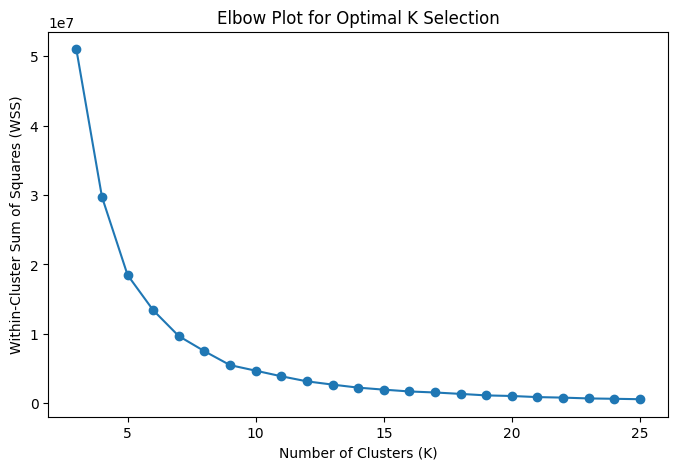

In [ ]:
# Evaluating clustering performance on varying K values
determine_optimal_k(combined_df, max_k = 25)

In [217]:
# Setting a K of 18 and placing players into relative value tiers
final_df = segment_players(combined_df, k = 18)

In [218]:
# Sorting final dataframe based on relative value, player value tier & position rank
final_df = final_df.sort_values(by = ['relative_value', 'player_value_tier', 'position_rank'], ascending = False)

In [219]:
display(final_df)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points,final_projection,initial_rank,position_group,relative_value,final_ranking,position_rank,player_value_tier
83,19755.0,Shohei Ohtani,29.0,LAD,OF,1604.961304,1737.0,1644.572900,1.0,OF,4556.627027,1.0,1.0,1
10,25764.0,Bobby Witt Jr.,24.0,KC,SS,1474.433838,1604.0,1513.303638,2.0,IF,4001.305370,2.0,1.0,2
101,15640.0,Aaron Judge,32.0,NYY,OF,1490.744629,1712.0,1557.121240,1.0,OF,3708.297913,3.0,2.0,3
48,13510.0,Jose Ramirez,31.0,CLE,3B,1462.773438,1514.0,1478.141406,3.0,IF,3607.438722,4.0,1.0,3
138,20123.0,Juan Soto,25.0,NYM,OF,1485.821655,1623.0,1526.975195,2.0,OF,3431.641936,5.0,3.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,24262.0,Ceddanne Rafaela,23.0,BOS,2B,816.478027,816.0,816.334607,97.0,IF,-1135.390586,284.0,23.0,18
80,16442.0,Ryan O'Hearn,30.0,BAL,1B,827.286743,778.0,812.500708,98.0,IF,-1148.092016,285.0,27.0,18
86,22514.0,Triston Casas,24.0,BOS,1B,644.122375,1192.0,808.485651,99.0,IF,-1161.211168,286.0,28.0,18
3,22581.0,Alejandro Kirk,25.0,TOR,C,838.857849,735.0,807.700500,100.0,IF,-1163.754818,287.0,12.0,18


In [ ]:
final_df.to_csv(f'data/predictions_{datetime.now().strftime('%Y-%m-%d')}.csv', index=False)